In [ ]:
import faiss
import torch
import json
import os  
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 
import insightface
from insightface.app import FaceAnalysis
from datasets import Dataset, Image as HFImage
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import (
    DonutProcessor, 
    VisionEncoderDecoderModel, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer
)

# --- Setup Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")
print(f"Faiss version: {faiss.__version__}")
print(f"Torch version: {torch.__version__}")

# --- Initialize SOTA Face Model (ArcFace) ---
print("🚀 Initializing SOTA Face Model (ArcFace)...")
# providers=['CUDAExecutionProvider'] requires ONNX Runtime GPU. 
# If it fails, it will fall back to CPU.
face_app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
face_app.prepare(ctx_id=0, det_size=(640, 640))

In [ ]:
def select_folder(title="Select Folder"):
    """Opens a dialog to select a folder."""
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    return filedialog.askdirectory(title=title)

def select_file(title="Select File", filetypes=[("All Files", "*.*")]):
    """Opens a dialog to select a file."""
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    return filedialog.askopenfilename(title=title, filetypes=filetypes)


In [ ]:
# ==========================================
# DATA LOADING CONFIGURATION
# ==========================================
print("📂 Please select the ROOT folder (containing 'positive', 'meta', 'fraud1...', etc.)")
root_dir = select_folder("Select IDNet Root Folder")

if not root_dir:
    print("❌ Selection cancelled.")
else:
    print(f"\n✅ Root: {root_dir}")

# Define ALL Use Case Folders
target_folders = [
    "positive",
    "fraud1_copy_and_move",
    "fraud2_face_morphing",
    "fraud3_face_replacement",
    "fraud4_combined",
    "fraud5_inpaint_and_rewrite",
    "fraud6_crop_and_replace"
]


In [ ]:
# --- Load Metadata ---
meta_base_dir = os.path.join(root_dir, "meta")
meta_subfolders = ["positive_meta", "detailed_with_fraud_info"]
metadata_map = {}

if os.path.exists(meta_base_dir):
    print("⏳ Loading metadata files...")
    for subfolder in meta_subfolders:
        full_sub_path = os.path.join(meta_base_dir, subfolder)
        if os.path.exists(full_sub_path):
            print(f"   Processing: {subfolder}...")
            for filename in os.listdir(full_sub_path):
                if filename.lower().endswith(".json") or filename.lower().endswith(".jsonl"):
                    full_path = os.path.join(full_sub_path, filename)
                    try:
                        # ✅ FIX: Force UTF-8 encoding
                        with open(full_path, 'r', encoding='utf-8') as f:
                            if filename.endswith('.jsonl'):
                                raw_data = [json.loads(line) for line in f]
                            else:
                                raw_data = json.load(f)
                            
                            if isinstance(raw_data, list):
                                for item in raw_data:
                                    key = item.get('file_name') or item.get('image_id') or item.get('id')
                                    if key: metadata_map[key] = item
                            elif isinstance(raw_data, dict):
                                metadata_map.update(raw_data)
                    except Exception as e:
                        print(f"⚠️ Error reading {filename}: {e}")
    print(f"✅ Loaded combined metadata for {len(metadata_map)} items.")
else:
    print("❌ 'meta' folder not found!")


In [ ]:
# --- Load Images & Match Metadata ---
dataset_samples = []
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

print("⚙️  Scanning image folders...")

for folder_name in target_folders:
    folder_path = os.path.join(root_dir, folder_name)
    if not os.path.exists(folder_path):
        print(f"⚠️ Warning: Folder not found: {folder_name} (Skipping)")
        continue
        
    print(f"   Scanning: {folder_name}...")
    count = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in valid_extensions:
                file_path = os.path.join(root, file)
                
                # Match metadata
                key = file 
                meta = metadata_map.get(key)
                if not meta: meta = metadata_map.get(os.path.splitext(file)[0])

                if meta:
                    # Tag the data with the specific Use Case/Fraud Type
                    is_fraud = "positive" not in folder_name
                    meta_copy = meta.copy()
                    meta_copy["is_fraud"] = is_fraud
                    meta_copy["fraud_type"] = folder_name if is_fraud else "none"

                    # ✅ FIX: Convert Dict to String here to satisfy PyArrow
                    dataset_samples.append({
                        "image": file_path,
                        "text": json.dumps(meta_copy) 
                    })
                    count += 1
    print(f"      -> Found {count} matched images.")

if len(dataset_samples) == 0:
    print("❌ No matching images found.")


In [ ]:
# Convert to HuggingFace Dataset
if len(dataset_samples) > 0:
    hf_dataset = Dataset.from_list(dataset_samples)
    hf_dataset = hf_dataset.cast_column("image", HFImage())
    print("✅ Dataset object created successfully.")
else:
    print("❌ Dataset creation failed (0 samples).")


In [ ]:
# ==========================================
# MODEL TRAINING SETUP
# ==========================================
model_save_path = "custom_trained_donut_model"
max_length = 512
image_size = [1280, 960]

# Initialize Processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.tokenizer.chat_template = None 
processor.feature_extractor.size = image_size[::-1]
processor.feature_extractor.do_align_long_axis = False

new_special_tokens = ["<s_name>", "</s_name>", "<s_id>", "</s_id>", "<s_address>", "</s_address>"] 
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + ["<s>", "</s>"]})

# Generator Function
def transform_generator(sample):
    pixel_values = processor(sample["image"].convert("RGB"), random_padding=True, return_tensors="pt").pixel_values.squeeze()
    
    # ✅ FIX: text is already a string now, no need to json.dumps() again
    text_str = sample["text"] 
    target_sequence = "<s>" + text_str + "</s>"
    
    input_ids = processor.tokenizer(
        target_sequence, add_special_tokens=False, max_length=max_length,
        padding="max_length", truncation=True, return_tensors="pt",
    )["input_ids"].squeeze(0)
    
    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }

# Prepare Iterable Dataset
iterable_dataset = hf_dataset.to_iterable_dataset()
processed_iterable_dataset = iterable_dataset.map(transform_generator)
shuffled_dataset = processed_iterable_dataset.shuffle(seed=42, buffer_size=100)


In [ ]:
try:
    # Initialize Model
    model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
    model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    model.decoder.resize_token_embeddings(len(processor.tokenizer))
    model.config.encoder.image_size = image_size[::-1]
    model.config.decoder.max_length = max_length
    
    # Training Arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="training_output",
        max_steps=100, # Set low for testing, increase for real training
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        fp16=torch.cuda.is_available(),
        logging_steps=10,
        save_steps=50,
        remove_unused_columns=True,
    )

    trainer = Seq2SeqTrainer(
        model=model, 
        args=training_args, 
        train_dataset=shuffled_dataset, 
    )

    print("🚀 Starting Training...")
    trainer.train()
    trainer.save_model(model_save_path)
    processor.save_pretrained(model_save_path)
    print(f"✅ Model saved to {model_save_path}")

except Exception as e:
    print(f"❌ Training failed: {e}")


#### Load Saved Custom Trained Donut Model

In [ ]:
import os
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel

def load_custom_donut(model_path="custom_trained_donut_model"):
    """
    Loads the fine-tuned Donut model and processor from disk.
    Returns: (model, processor) or (None, None) if failed.
    """
    print(f"⏳ Loading Donut model from folder: '{model_path}'...")
    
    # 1. Check if the folder actually exists
    if not os.path.exists(model_path):
        print(f"❌ Error: The folder '{model_path}' does not exist.")
        print("   👉 You must run the 'Training' block at least once to create it.")
        return None, None

    try:
        # 2. Determine Device (GPU is much faster)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # 3. Load the Model Weights (pytorch_model.bin)
        # This reconstructs the exact neural network you saved.
        model = VisionEncoderDecoderModel.from_pretrained(model_path)
        model.to(device) # Move to GPU
        model.eval()     # Switch to Inference Mode (Critical for accuracy)
        
        # 4. Load the Processor (Tokenizer + Image config)
        # This ensures we process images exactly how the model expects them.
        processor = DonutProcessor.from_pretrained(model_path)
        
        print(f"✅ Custom Donut Model loaded successfully on {device}!")
        return model, processor

    except Exception as e:
        print(f"❌ Critical Error loading model: {e}")
        return None, None

# --- HOW TO USE IT ---
# Instead of training every time, just run this line:
loaded_model, loaded_processor = load_custom_donut()

# If it loaded correctly, you can now update your extraction function to use it:
if loaded_model:
    # Update the global variables so the rest of your code uses the loaded version
    model = loaded_model
    processor = loaded_processor


### Large Training for Entire 5,00 - 20,000 Images

In [ ]:
"""try:
    # Initialize Model
    model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
    model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    model.decoder.resize_token_embeddings(len(processor.tokenizer))
    model.config.encoder.image_size = image_size[::-1]
    model.config.decoder.max_length = max_length
    
    # --- REAL TRAINING CONFIGURATION ---
    # Calculate steps based on dataset size
    # If you have 10,000 images and batch size 2, one epoch is 5,000 steps.
    # A good training run is usually 3 to 5 epochs.
    
    # Assuming roughly 5,000 - 10,000 images in IDNet:
    REAL_STEPS = 5000  
    
    training_args = Seq2SeqTrainingArguments(
        output_dir="training_output",
        
        # 1. INCREASE STEPS
        max_steps=REAL_STEPS,           # Changed from 100 to 5000
        
        # 2. OPTIMIZE LEARNING RATE
        learning_rate=1e-5,             # Slightly lower rate for stability over long runs
        warmup_steps=200,               # Gently ramp up speed at the start
        
        # 3. BATCH SIZE (Crucial for GPU Memory)
        # If you get "CUDA Out of Memory", change this to 1
        per_device_train_batch_size=2,  
        gradient_accumulation_steps=4,  # Simulates a batch size of 8 (2 * 4) for better convergence
        
        # 4. HARDWARE ACCELERATION
        fp16=torch.cuda.is_available(), # Use mixed precision (faster, less memory)
        
        # 5. LOGGING & SAVING
        logging_steps=100,              # Log progress every 100 steps
        save_steps=1000,                # Save a checkpoint every 1000 steps (so you don't lose progress)
        save_total_limit=2,             # Only keep the last 2 checkpoints to save disk space
        remove_unused_columns=True,
    )

    trainer = Seq2SeqTrainer(
        model=model, 
        args=training_args, 
        train_dataset=shuffled_dataset, 
    )

    print(f"🚀 Starting REAL Training for {REAL_STEPS} steps...")
    print("This may take several hours. Monitor the loss (it should go down).")
    
    trainer.train()
    
    # Save final model
    trainer.save_model(model_save_path)
    processor.save_pretrained(model_save_path)
    print(f"✅ Training Complete! Model saved to {model_save_path}")

except Exception as e:
    print(f"❌ Training failed: {e}")
    # Troubleshooting tip
    if "out of memory" in str(e).lower():
        print("💡 TIP: Reduce 'per_device_train_batch_size' to 1 and restart.")
"""

### Continued Code

In [ ]:
# ==========================================
# INDEXING (Uses all Folders)
# ==========================================
print("🏗️  Building Indexes from loaded dataset...")

face_embeddings = []
text_documents = []
metadata_store = []

for idx, item in enumerate(tqdm(hf_dataset)):
    image = item['image'].convert("RGB")
    text_data = item['text'] # Already a string
    
    # 1. Face Embedding
    open_cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    faces = face_app.get(open_cv_image)
    
    if len(faces) > 0:
        emb = faces[0].normed_embedding.astype('float32')
    else:
        emb = np.zeros(512).astype('float32')
        
    face_embeddings.append(emb)
    text_documents.append(text_data)
    
    metadata_store.append({
        "id": idx,
        "data": text_data
    })

# FAISS Setup
face_embeddings = np.array(face_embeddings).astype('float32')
d = 512
if torch.cuda.is_available():
    res = faiss.StandardGpuResources()
    face_index = faiss.GpuIndexFlatL2(res, d)
else:
    face_index = faiss.IndexFlatL2(d)
face_index.add(face_embeddings)

# TF-IDF Setup
tfidf_vectorizer = TfidfVectorizer()
text_matrix = tfidf_vectorizer.fit_transform(text_documents)

print("✅ Search Indexes Ready!")


## Save and Load Index

In [ ]:
import pickle

# 1. Save Metadata Store
with open("metadata_store.pkl", "wb") as f:
    pickle.dump(metadata_store, f)

# 2. Save FAISS Index
# Note: GPU indexes must be moved to CPU before saving
if torch.cuda.is_available():
    cpu_index = faiss.index_gpu_to_cpu(face_index)
    faiss.write_index(cpu_index, "face_index.bin")
else:
    faiss.write_index(face_index, "face_index.bin")

# 3. Save TF-IDF Vectorizer and Matrix
with open("tfidf_data.pkl", "wb") as f:
    pickle.dump((tfidf_vectorizer, text_matrix), f)

print("✅ All indexes and metadata saved to disk!")

In [ ]:
import pickle

# Check if files exist first
if os.path.exists("metadata_store.pkl") and os.path.exists("face_index.bin"):
    print("⏳ Loading indexes from disk...")

    # 1. Load Metadata
    with open("metadata_store.pkl", "rb") as f:
        metadata_store = pickle.load(f)

    # 2. Load FAISS Index
    face_index = faiss.read_index("face_index.bin")
    # Optional: Move back to GPU for speed
    if torch.cuda.is_available():
        res = faiss.StandardGpuResources()
        face_index = faiss.index_cpu_to_gpu(res, 0, face_index)

    # 3. Load TF-IDF
    with open("tfidf_data.pkl", "rb") as f:
        tfidf_vectorizer, text_matrix = pickle.load(f)

    print(f"✅ Loaded {len(metadata_store)} items from disk. Ready to search!")
else:
    print("❌ No saved indexes found. Please run the 'Indexing' block first.")


## Continue Training 

In [ ]:
"""def extract_text_donut(image):
   #Extracts text from an image using the trained Donut model.
    model = VisionEncoderDecoderModel.from_pretrained(model_save_path).to(device)
    proc = DonutProcessor.from_pretrained(model_save_path)
    pixel_values = proc(image, return_tensors="pt").pixel_values.to(device)
    task_prompt = "<s>"
    decoder_input_ids = proc.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            pixel_values, decoder_input_ids=decoder_input_ids, max_length=512,
            return_dict_in_generate=True
        )
    return proc.batch_decode(outputs.sequences)[0]"""

def extract_text_donut(image):
    """
    Extracts text using the GLOBALLY loaded model and processor.
    This is much faster because we don't reload the model for every single image.
    """
    # Safety Check: Ensure model is actually loaded
    if 'model' not in globals() or 'processor' not in globals() or model is None:
        print("⚠️ Model not loaded! Running fallback text extraction...")
        return "" 

    device = model.device # Get device from the model itself (cpu or cuda)

    # 1. Prepare Image
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    
    # 2. Prepare Prompt (Start Token)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(
        task_prompt, 
        add_special_tokens=False, 
        return_tensors="pt"
    ).input_ids.to(device)
    
    # 3. Generate Output
    with torch.no_grad():
        outputs = model.generate(
            pixel_values, 
            decoder_input_ids=decoder_input_ids, 
            max_length=512,
            return_dict_in_generate=True
        )
    
    # 4. Decode to String
    sequence = processor.batch_decode(outputs.sequences)[0]
    
    # 5. Clean up the output string (Remove <s> and </s> tokens)
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    # Also remove the start token if it appears
    sequence = sequence.replace("<s>", "")
    
    return sequence

def search_pipeline(query_image_path, k=5, alpha=0.5):
    """Hybrid search using Face Embeddings and OCR Text."""
    query_img = Image.open(query_image_path).convert("RGB")
    img_cv2 = cv2.imread(query_image_path)
    
    # Face Scores
    face_scores = np.zeros(len(metadata_store))
    if alpha > 0:
        faces = face_app.get(img_cv2)
        if len(faces) > 0:
            q_emb = faces[0].normed_embedding.reshape(1, -1).astype('float32')
            D, I = face_index.search(q_emb, k * 10) # Search wider then filter
            for rank, idx in enumerate(I[0]):
                if idx == -1: continue
                face_scores[idx] = 1 / (1 + D[0][rank])

    # Text Scores
    text_scores = np.zeros(len(metadata_store))
    if alpha < 1:
        extracted_text = extract_text_donut(query_img)
        q_vec = tfidf_vectorizer.transform([extracted_text])
        sims = cosine_similarity(q_vec, text_matrix).flatten()
        text_scores = sims

    # Combine Scores
    final_scores = (alpha * face_scores) + ((1 - alpha) * text_scores)
    top_indices = np.argsort(final_scores)[::-1][:k]
    
    results = []
    for idx in top_indices:
        results.append({
            "id": idx,
            "score": final_scores[idx],
            "metadata": metadata_store[idx]
        })
    return results, query_img


In [ ]:
import math

print("📂 Select a query ID card image...")
query_path = select_file("Select Query Image")

if query_path:
    print(f"🔎 Searching for: {query_path}")
    
    # User Input for Search Mode
    mode_map = {'1': "Face Only", '2': "Text Only", '3': "Hybrid"}
    mode_input = input("Select Mode: [1] Face Only  [2] Text Only  [3] Hybrid (Default): ")
    alpha = 1.0 if mode_input == '1' else (0.0 if mode_input == '2' else 0.5)
    selected_mode = mode_map.get(mode_input, "Hybrid")
    
    # Search Pipeline (k=10 for detailed audit)
    K_RESULTS = 10
    results, q_img = search_pipeline(query_path, k=K_RESULTS, alpha=alpha)
    
    print("\n" + "="*80)
    print(f"🔍 AUDIT REPORT | Mode: {selected_mode} | Alpha: {alpha}")
    print("="*80)
    
    # --- VISUALIZATION SETUP ---
    # Calculate grid size dynamically (e.g. 2 rows of 6)
    total_plots = len(results) + 1
    cols = 6
    rows = math.ceil(total_plots / cols)
    
    plt.figure(figsize=(20, 4 * rows))
    
    # Plot 1: The Query Image
    plt.subplot(rows, cols, 1)
    plt.imshow(q_img)
    plt.title("QUERY INPUT\n(Source Artifact)", color='blue', weight='bold')
    plt.axis("off")
    
    # --- DETAILED RESULT LOOP ---
    for i, res in enumerate(results):
        rank = i + 1
        score = res['score']
        
        # 1. Deep Metadata Extraction
        # The 'data' field is a JSON string we need to parse
        try:
            meta_dict = json.loads(res['metadata']['data'])
            is_fraud = meta_dict.get('is_fraud', False)
            fraud_type = meta_dict.get('fraud_type', 'None')
            
            # Extract PII for Audit (Obfuscated for privacy if needed)
            audit_id = meta_dict.get('id', 'N/A')
            audit_name = meta_dict.get('name', 'N/A')
            audit_dob = meta_dict.get('dob', 'N/A')
            
        except json.JSONDecodeError:
            is_fraud = False
            fraud_type = "METADATA_ERROR"
            audit_id = "ERR"
            
        # 2. Status Logic
        status_label = "🚨 FRAUD DETECTED" if is_fraud else "✅ AUTHENTIC"
        status_color = 'red' if is_fraud else 'green'
        
        # 3. Console Audit Log (Extreme Detail)
        print(f"\n[RANK #{rank}] Score: {score:.4f} | Status: {status_label}")
        print(f"   ├─ 🆔 Database ID: {res['id']}")
        print(f"   ├─ 🎭 Fraud Type:  {fraud_type.upper()}")
        print(f"   ├─ 📄 Document Metadata:")
        print(f"   │    ├─ Name: {audit_name}")
        print(f"   │    ├─ DOB:  {audit_dob}")
        print(f"   │    └─ File: {meta_dict.get('file_name', 'Unknown')}")
        print(f"   └─ 🧮 Match Logic: (Alpha={alpha})")
        
        # 4. Visualization Plot
        match_img = hf_dataset[int(res['id'])]['image']
        
        plt.subplot(rows, cols, i + 2)
        plt.imshow(match_img)
        
        # Detailed Plot Title
        title_text = (
            f"#{rank} {status_label}\n"
            f"Score: {score:.2f}\n"
            f"Type: {fraud_type}"
        )
        plt.title(title_text, color=status_color, fontsize=9)
        
        # Add a border color to the image based on status
        # (Matplotlib hack: draw a box around the axis)
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor(status_color)
            spine.set_linewidth(3)
            
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    print("\n" + "="*80)
    print("✅ End of Audit Report")
    print("="*80)

else:
    print("❌ Selection Cancelled: No file selected.")


### UI Interactive Dashboard Output

📂 Select a query ID card image...



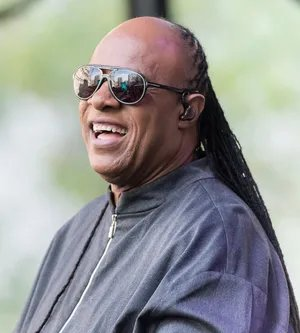
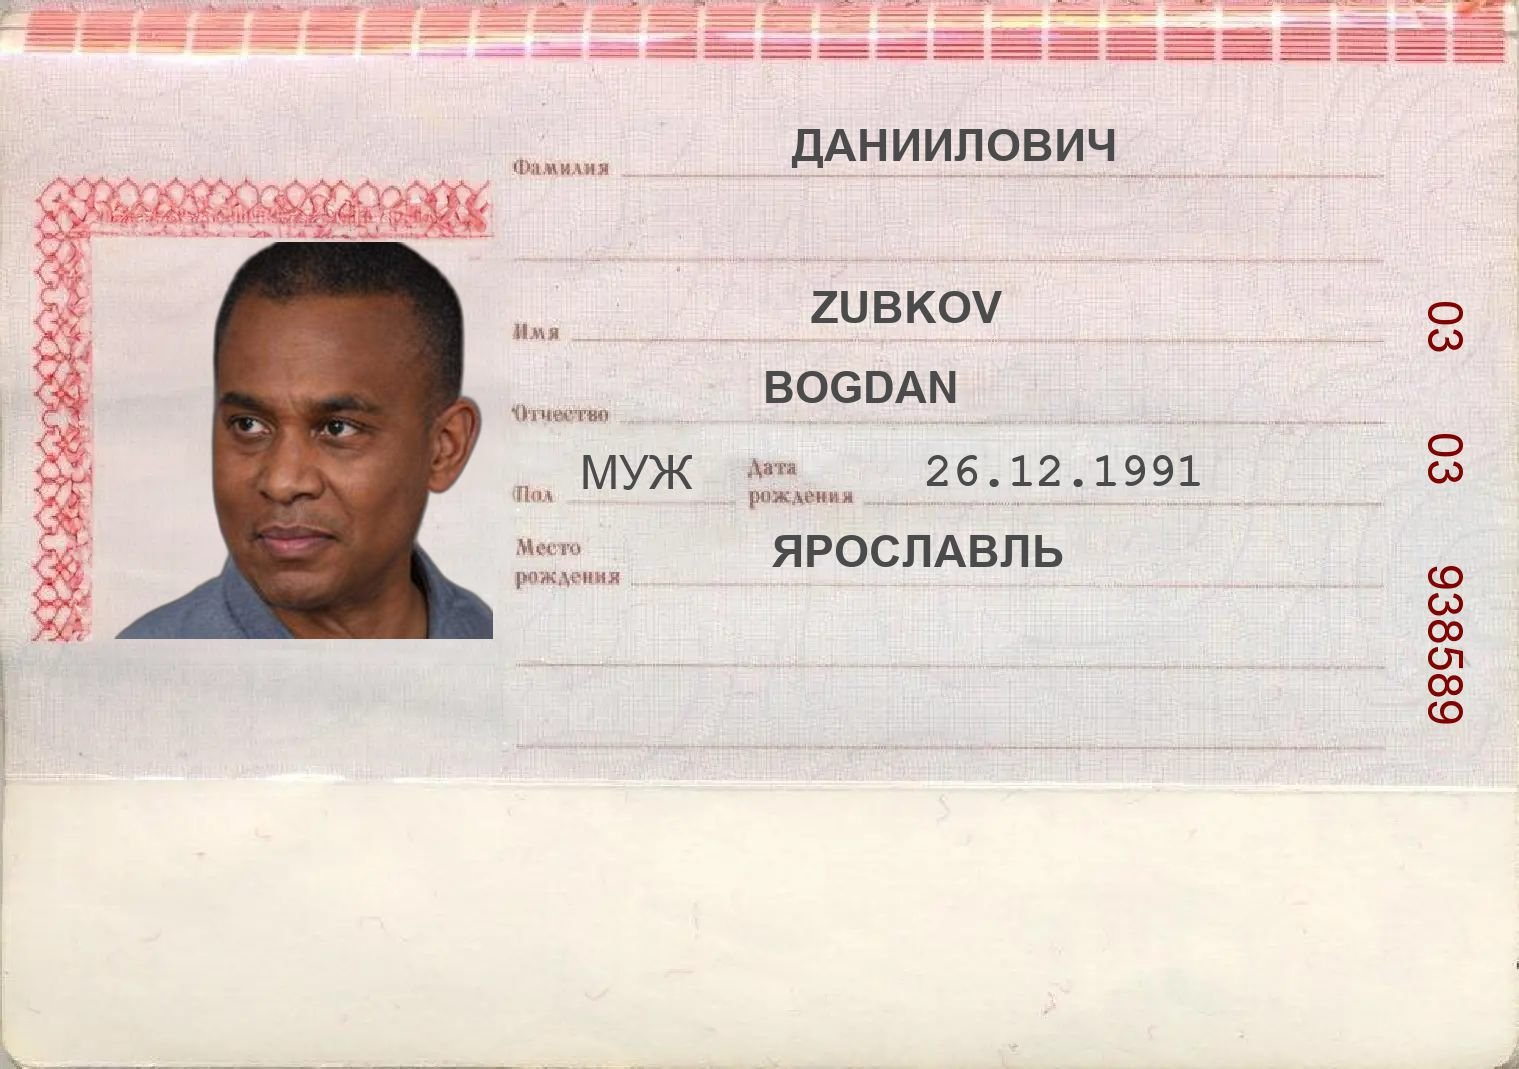
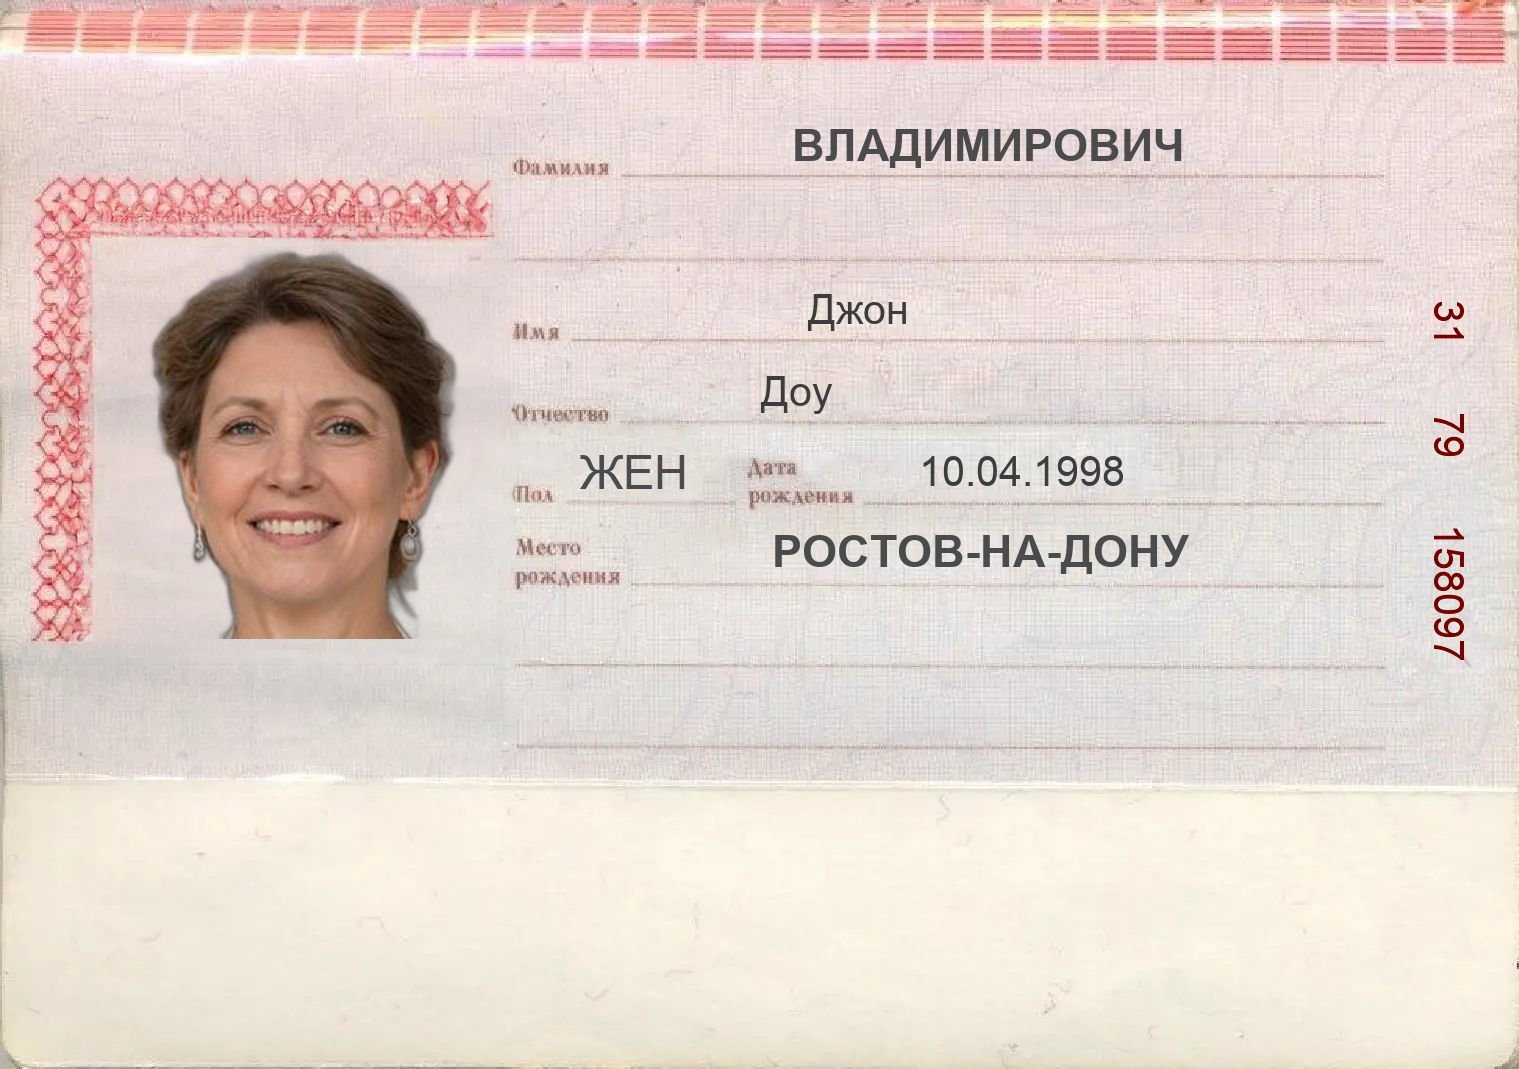
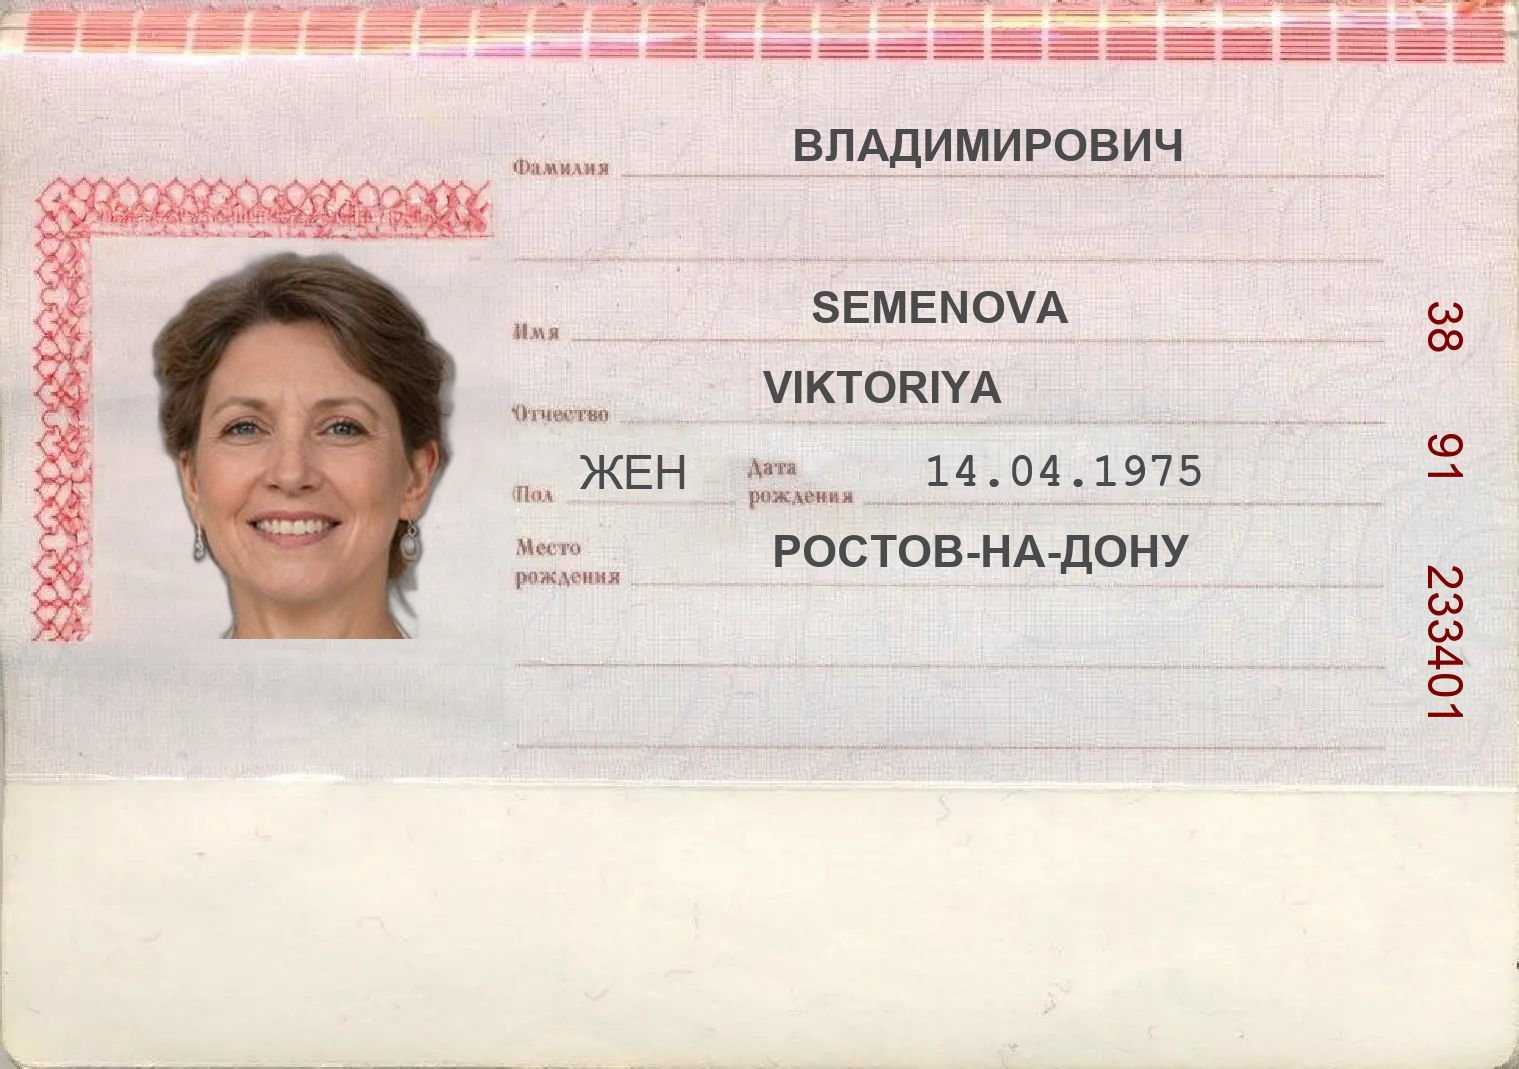

In [ ]:
import base64
import io
import json
import cv2
import numpy as np
from IPython.display import display, HTML
from PIL import Image

# --- Helper: Convert Image to Base64 ---
def img_to_base64(img):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG", quality=85)
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/jpeg;base64,{img_str}"

# --- Helper: Generate Main Dashboard HTML ---
def render_sparrow_dashboard(query_img, results, k, alpha):
    
    # 1. Calculate Dashboard Metrics
    top_score = results[0]['score'] if results else 0
    avg_score = np.mean([r['score'] for r in results]) if results else 0
    fraud_count = sum(1 for r in results if "fraud" in str(r['metadata']).lower() and "positive" not in str(r['metadata']).lower())
    mode_text = "Hybrid Search" if alpha == 0.5 else ("Face Only" if alpha == 1.0 else "Text Only")
    
    # 2. Convert Query Image
    query_b64 = img_to_base64(query_img)
    
    # 3. Styles (Dark Theme - #111111 Background)
    style = """
    <style>
        .sparrow-dash { font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif; background-color: #111111; color: #ffffff; padding: 20px; border-radius: 12px; }
        .header-bar { display: flex; justify-content: space-between; align-items: center; margin-bottom: 20px; border-bottom: 1px solid #333; padding-bottom: 10px; }
        .logo { font-size: 20px; font-weight: bold; color: #10B981; } /* Sparrow Green */
        
        /* Info Banner */
        .info-banner { background-color: #1A1A1A; border-left: 4px solid #10B981; padding: 15px; border-radius: 4px; margin-bottom: 24px; display: flex; align-items: center; }
        .info-icon { font-size: 24px; margin-right: 15px; color: #10B981; }
        
        /* Metric Cards Row */
        .metrics-grid { display: grid; grid-template-columns: repeat(4, 1fr); gap: 15px; margin-bottom: 30px; }
        .metric-card { background-color: #F3F4F6; color: #111; padding: 20px; border-radius: 8px; }
        .metric-label { display: flex; align-items: center; gap: 8px; font-size: 14px; color: #555; margin-bottom: 8px; font-weight: 500; }
        .metric-value { font-size: 28px; font-weight: bold; color: #000; }
        .metric-sub { font-size: 12px; color: #666; margin-top: 4px; }
        
        /* Results Section */
        .section-title { font-size: 14px; color: #888; margin-bottom: 10px; text-transform: uppercase; letter-spacing: 0.5px; }
        .results-container { display: flex; flex-direction: column; gap: 15px; }
        
        .result-card { background-color: #1A1A1A; border-radius: 8px; padding: 0; overflow: hidden; display: flex; border: 1px solid #333; }
        .result-img-box { width: 200px; height: 150px; background: #000; display: flex; align-items: center; justify-content: center; border-right: 1px solid #333; }
        .result-img { max-width: 100%; max-height: 100%; object-fit: contain; }
        
        .result-content { padding: 15px; flex: 1; display: flex; flex-direction: column; justify-content: center; }
        .result-header { display: flex; justify-content: space-between; align-items: start; margin-bottom: 10px; }
        .result-rank { color: #10B981; font-weight: bold; font-size: 14px; }
        .progress-bar-bg { background: #333; height: 6px; width: 100px; border-radius: 3px; margin-top: 5px; }
        .progress-bar-fill { height: 100%; background: #10B981; border-radius: 3px; }
        
        .meta-box { background: #111; border: 1px solid #333; padding: 10px; border-radius: 4px; font-family: monospace; font-size: 11px; color: #bbb; height: 60px; overflow-y: auto; }
    </style>
    """
    
    # 4. HTML Structure
    html = f"""
    {style}
    <div class="sparrow-dash">
        <!-- Header -->
        <div class="header-bar">
            <div class="logo">Sparrow</div>
            <div style="display: flex; gap: 10px;">
                <span style="background:#262626; padding: 5px 15px; border-radius: 15px; font-size: 12px;">Home</span>
                <span style="background:#333; padding: 5px 15px; border-radius: 15px; font-size: 12px; color: white;">Hub</span>
            </div>
        </div>
        
        <!-- Banner -->
        <div class="info-banner">
            <div class="info-icon">📈</div>
            <div>
                <div style="color: #10B981; font-weight: bold; margin-bottom: 4px;">Search Analysis</div>
                <div style="font-size: 13px; color: #ccc;">
                    Analysis complete. Found {len(results)} matches using <b>{mode}</b> (Top k={k}).
                </div>
            </div>
        </div>
        
        <!-- Metrics Grid (White Cards like Image) -->
        <div class="metrics-grid">
            <!-- Card 1 -->
            <div class="metric-card">
                <div class="metric-label"><span style="color:#10B981">📊</span> Total Matches</div>
                <div class="metric-value">{len(results)}</div>
                <div class="metric-sub">In database subset</div>
            </div>
            <!-- Card 2 -->
            <div class="metric-card">
                <div class="metric-label"><span style="color:#3B82F6">✓</span> Top Score</div>
                <div class="metric-value">{top_score*100:.1f}%</div>
                <div class="metric-sub">Confidence rating</div>
            </div>
             <!-- Card 3 -->
            <div class="metric-card">
                <div class="metric-label"><span style="color:#6366F1">⏱</span> Avg. Confidence</div>
                <div class="metric-value">{avg_score*100:.1f}%</div>
                <div class="metric-sub">Across top {k} results</div>
            </div>
             <!-- Card 4 -->
            <div class="metric-card">
                <div class="metric-label"><span style="color:#EF4444">🔍</span> Search Mode</div>
                <div class="metric-value" style="font-size: 22px;">{mode}</div>
                <div class="metric-sub">Alpha = {alpha}</div>
            </div>
        </div>
        
        <!-- Content Split: Query (Left) vs Results (Right) -->
        <div style="display: grid; grid-template-columns: 1fr 2fr; gap: 20px;">
            
            <!-- Left Col: Query Image -->
            <div>
                <div class="section-title">Query Input</div>
                <div style="background: #1A1A1A; padding: 15px; border-radius: 8px; border: 1px solid #333; text-align: center;">
                    <img src="{query_b64}" style="max-width: 100%; border-radius: 4px; margin-bottom: 10px;">
                    <div style="font-size: 12px; color: #666;">Source Input File</div>
                </div>
            </div>
            
            <!-- Right Col: Result List -->
            <div>
                <div class="section-title">Top Results Distribution</div>
                <div class="results-container">
    """
    
    # 5. Loop Results
    for i, res in enumerate(results):
        match_img = hf_dataset[int(res['id'])]['image']
        match_b64 = img_to_base64(match_img)
        
        # Parse Metadata
        try:
            meta_obj = json.loads(res['metadata']['data'])
            meta_pretty = json.dumps(meta_obj, indent=None) # Compact
            # Extract a few key fields for display
            fraud_type = meta_obj.get("fraud_type", "N/A")
            is_fraud = meta_obj.get("is_fraud", False)
            status_color = "#EF4444" if is_fraud else "#10B981"
            status_text = "FRAUD DETECTED" if is_fraud else "VERIFIED AUTHENTIC"
        except:
            meta_pretty = str(res['metadata']['data'])
            status_text = "Unknown"
            status_color = "#666"
            fraud_type = "Unknown"

        html += f"""
                    <div class="result-card">
                        <div class="result-img-box">
                            <img src="{match_b64}" class="result-img">
                        </div>
                        <div class="result-content">
                            <div class="result-header">
                                <div>
                                    <div class="result-rank">RANK #{i+1}</div>
                                    <div style="font-size: 18px; font-weight: bold; color: white;">{status_text}</div>
                                    <div style="font-size: 12px; color: #888;">Type: {fraud_type}</div>
                                </div>
                                <div style="text-align: right;">
                                    <div style="font-size: 24px; font-weight: bold; color: #fff;">{res['score']*100:.1f}%</div>
                                    <div class="progress-bar-bg">
                                        <div class="progress-bar-fill" style="width: {res['score']*100}%;"></div>
                                    </div>
                                </div>
                            </div>
                            <div class="meta-box">{meta_pretty[:300]}...</div>
                        </div>
                    </div>
        """

    html += """
                </div>
            </div>
        </div>
    </div>
    """
    
    display(HTML(html))

# --- Main Execution Block ---
print("📂 Select a query ID card image...")
query_path = select_file("Select Query Image", [("Images", "*.jpg;*.png;*.jpeg;*.bmp"), ("All files", "*.*")])

if query_path:
    # --- Run Search ---
    # Default to Hybrid (0.5)
    mode_input = input("Select Mode: [1] Face Only  [2] Text Only  [3] Hybrid (Default): ")
    alpha = 1.0 if mode_input == '1' else (0.0 if mode_input == '2' else 0.5)
    k = 3 # Show top 3 for cleaner dashboard layout
    
    results, q_img = search_pipeline(query_path, k=k, alpha=alpha)
    
    # --- Render Dashboard ---
    render_sparrow_dashboard(q_img, results, k, alpha)

else:
    print("❌ No file selected.")


📂 Select a query ID card image...



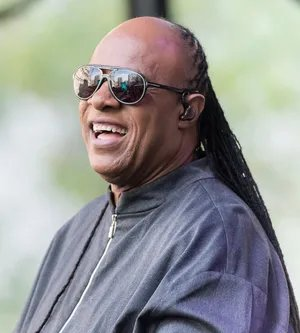
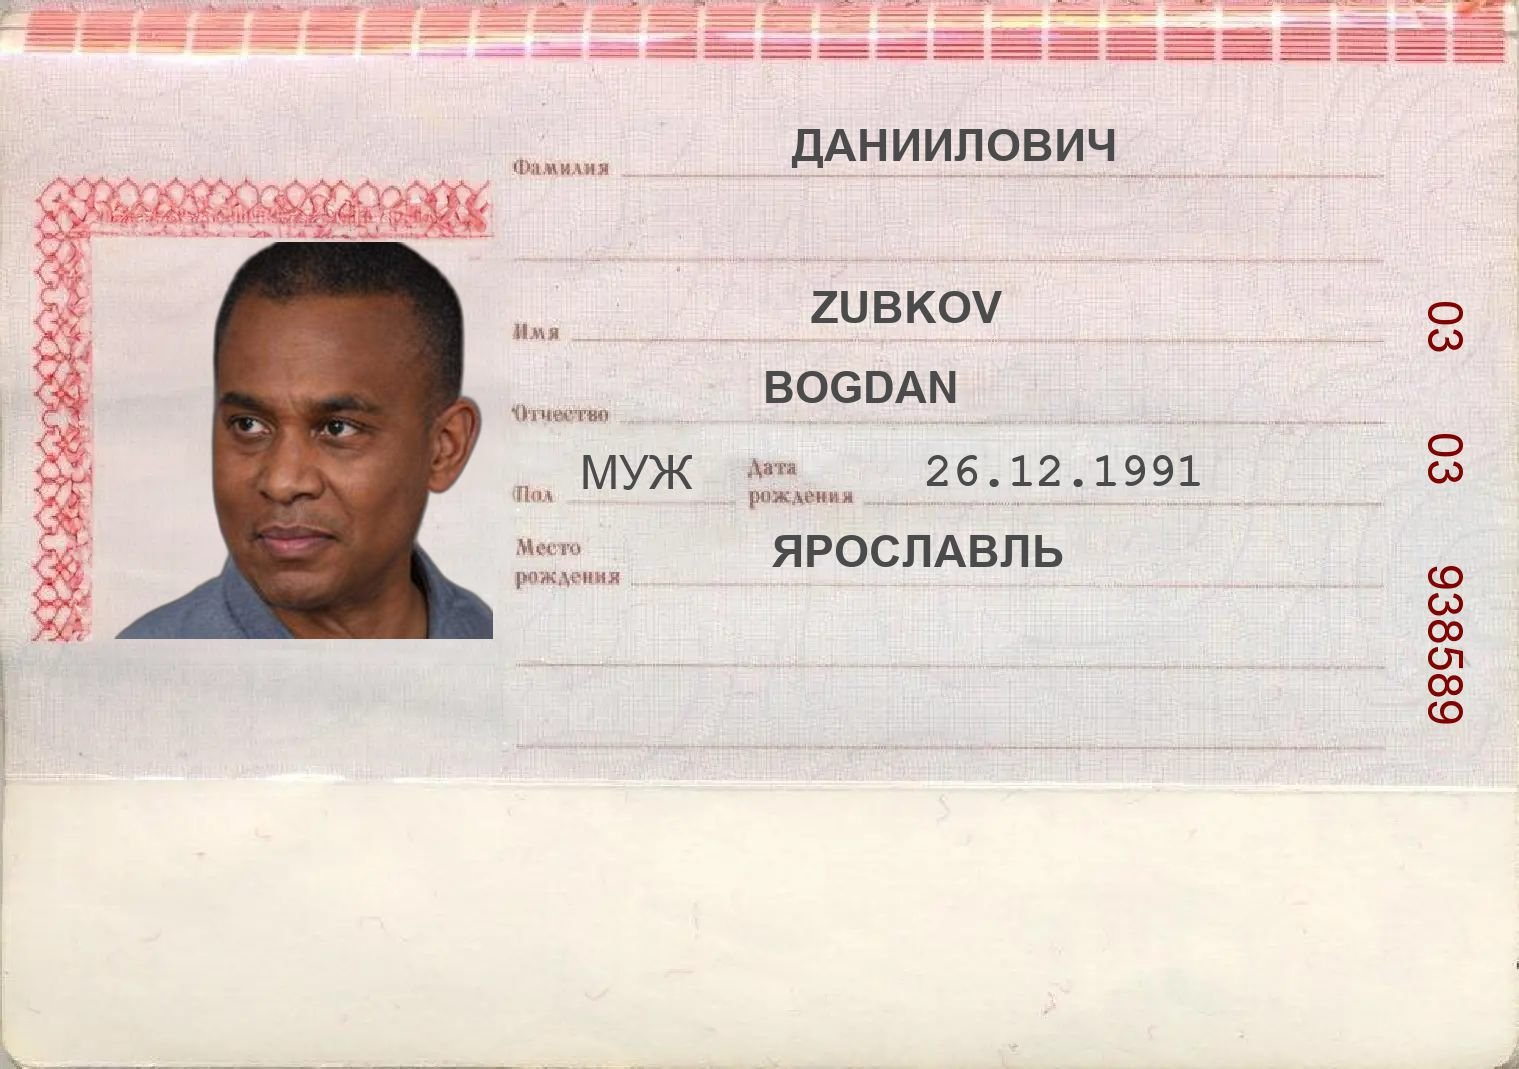
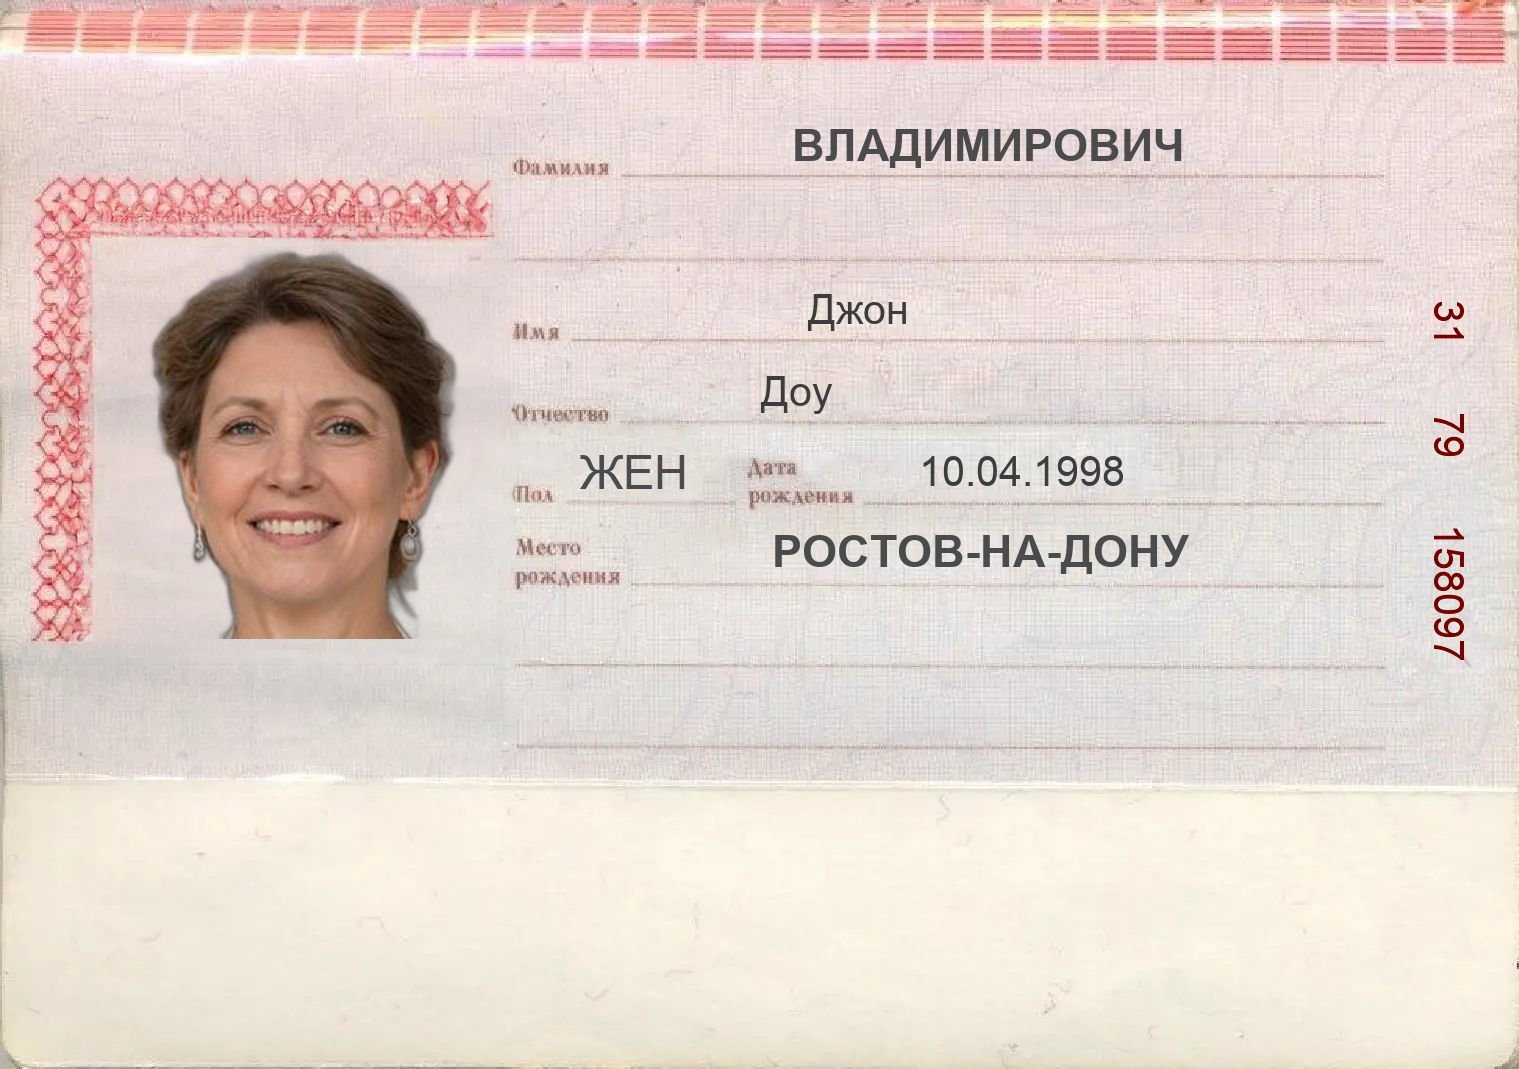
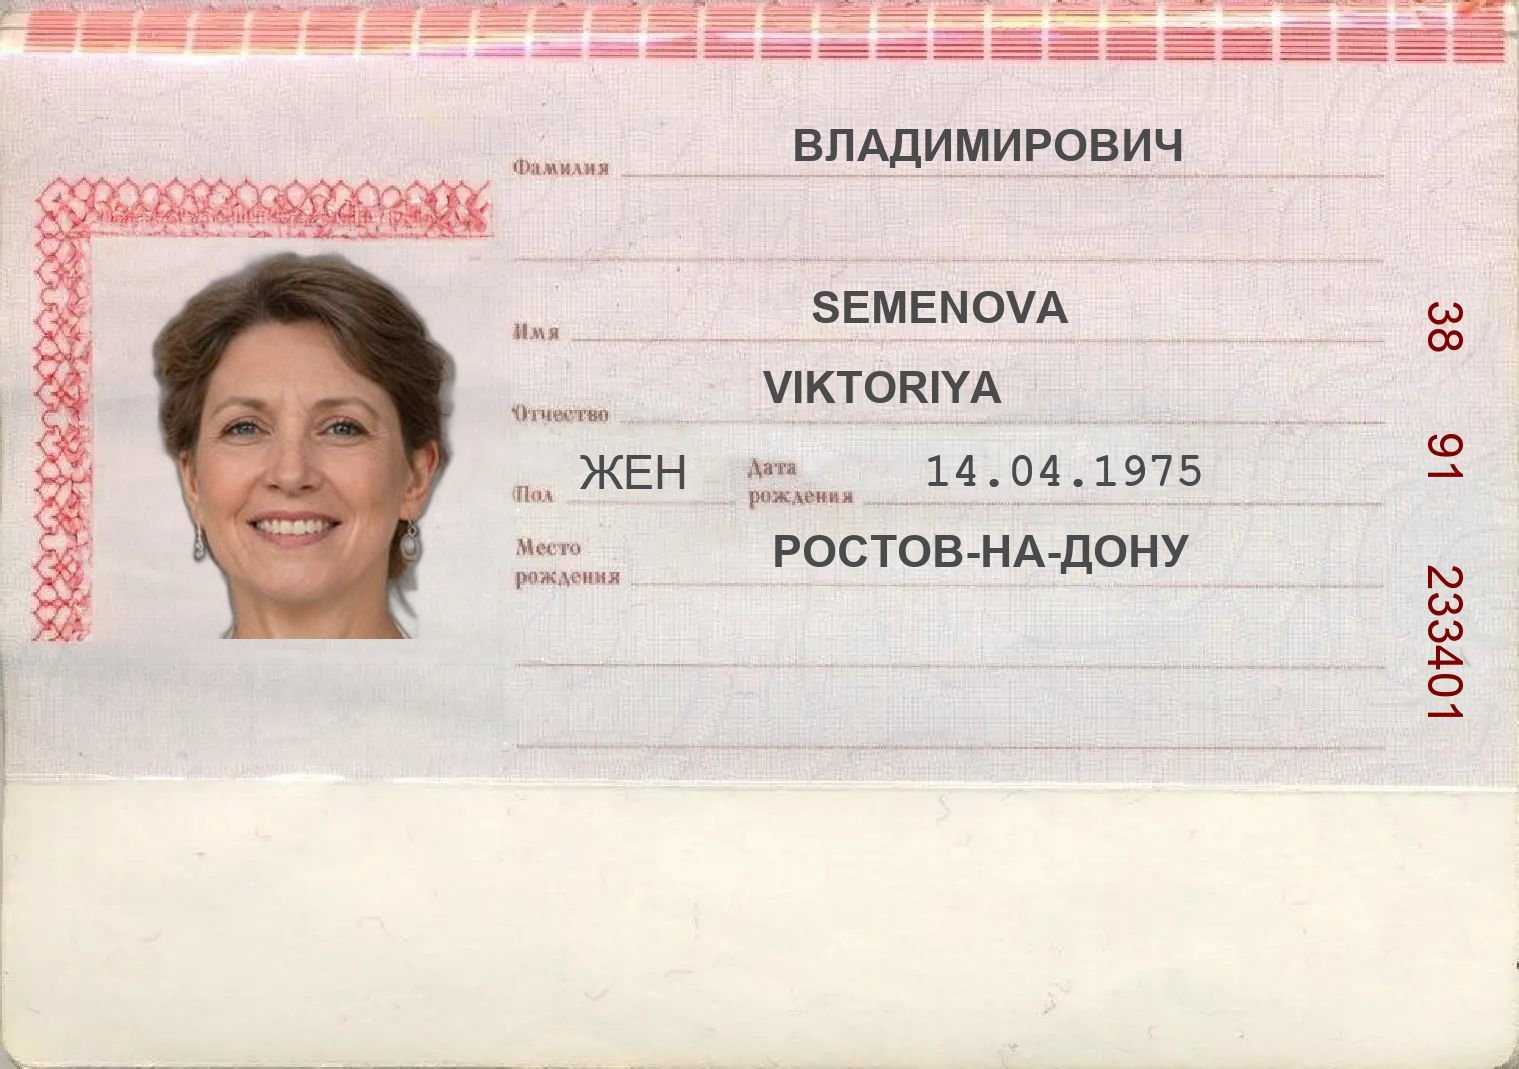
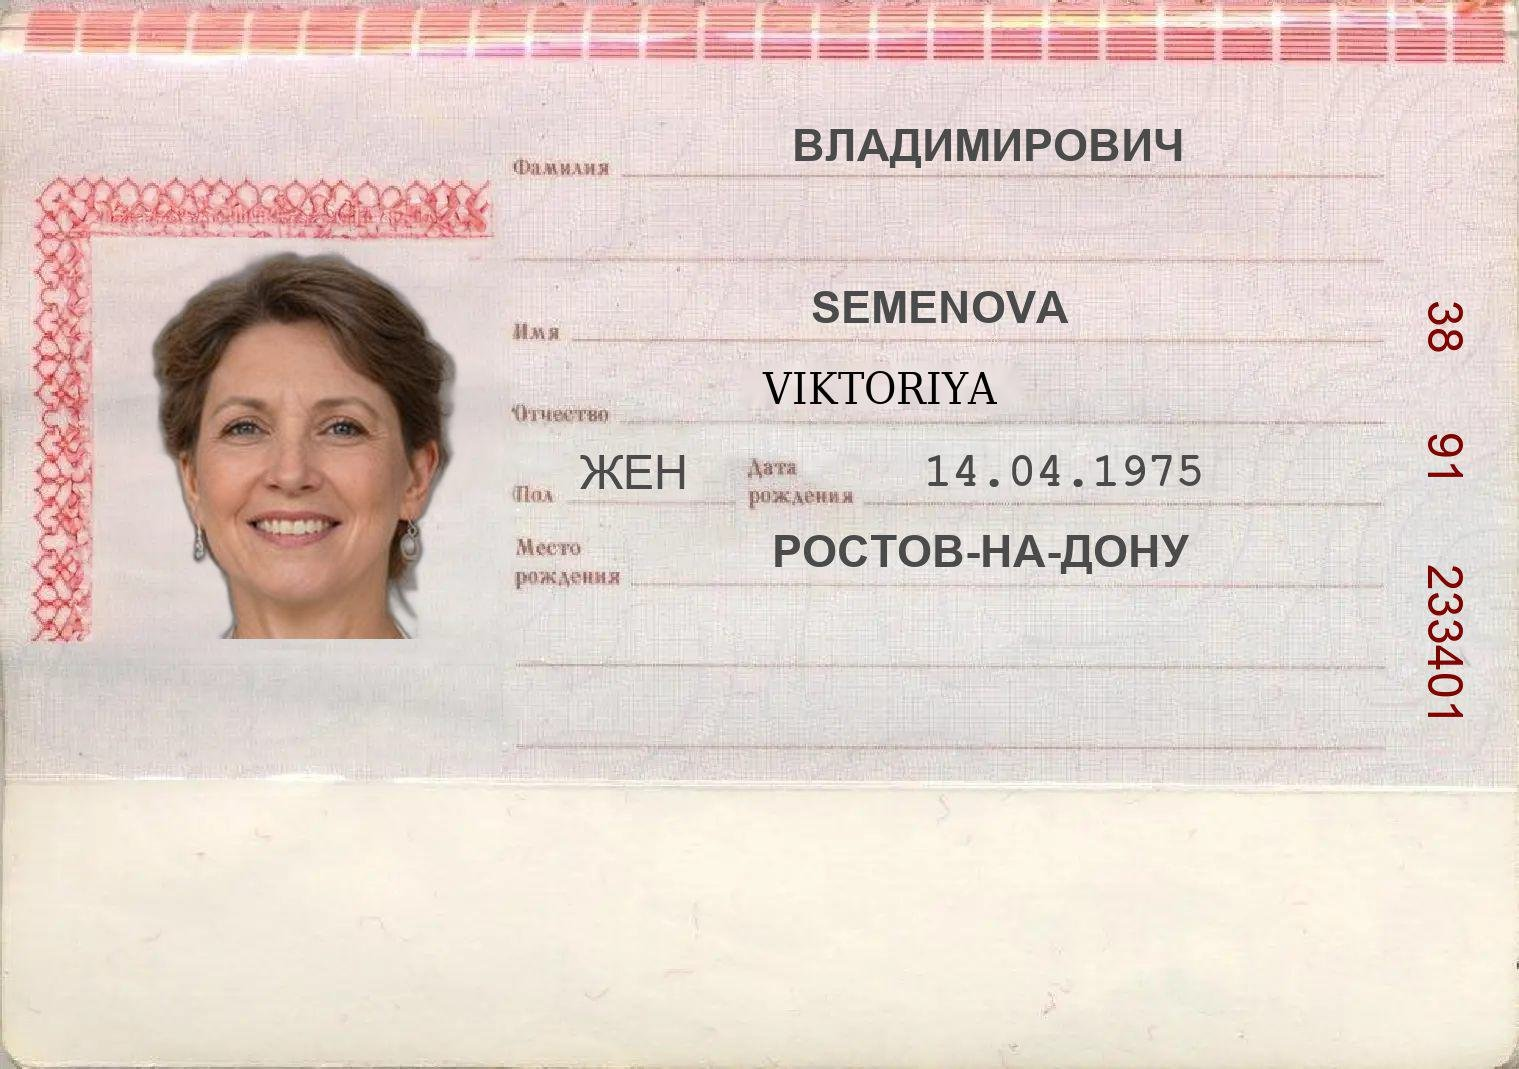
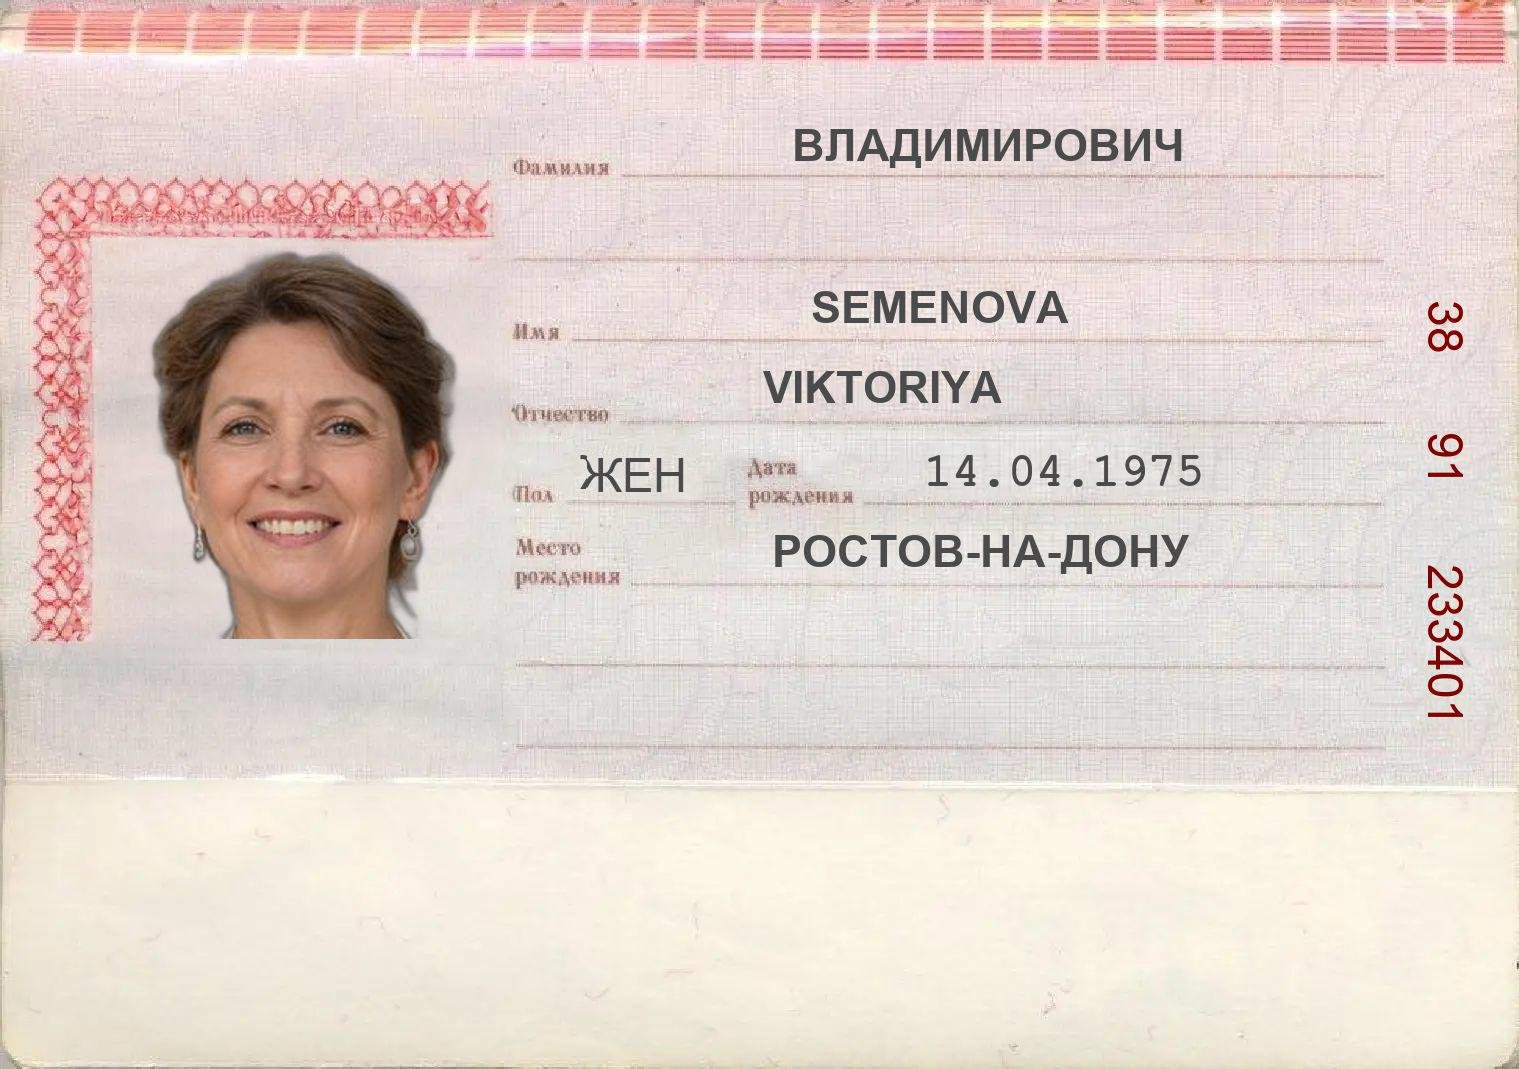
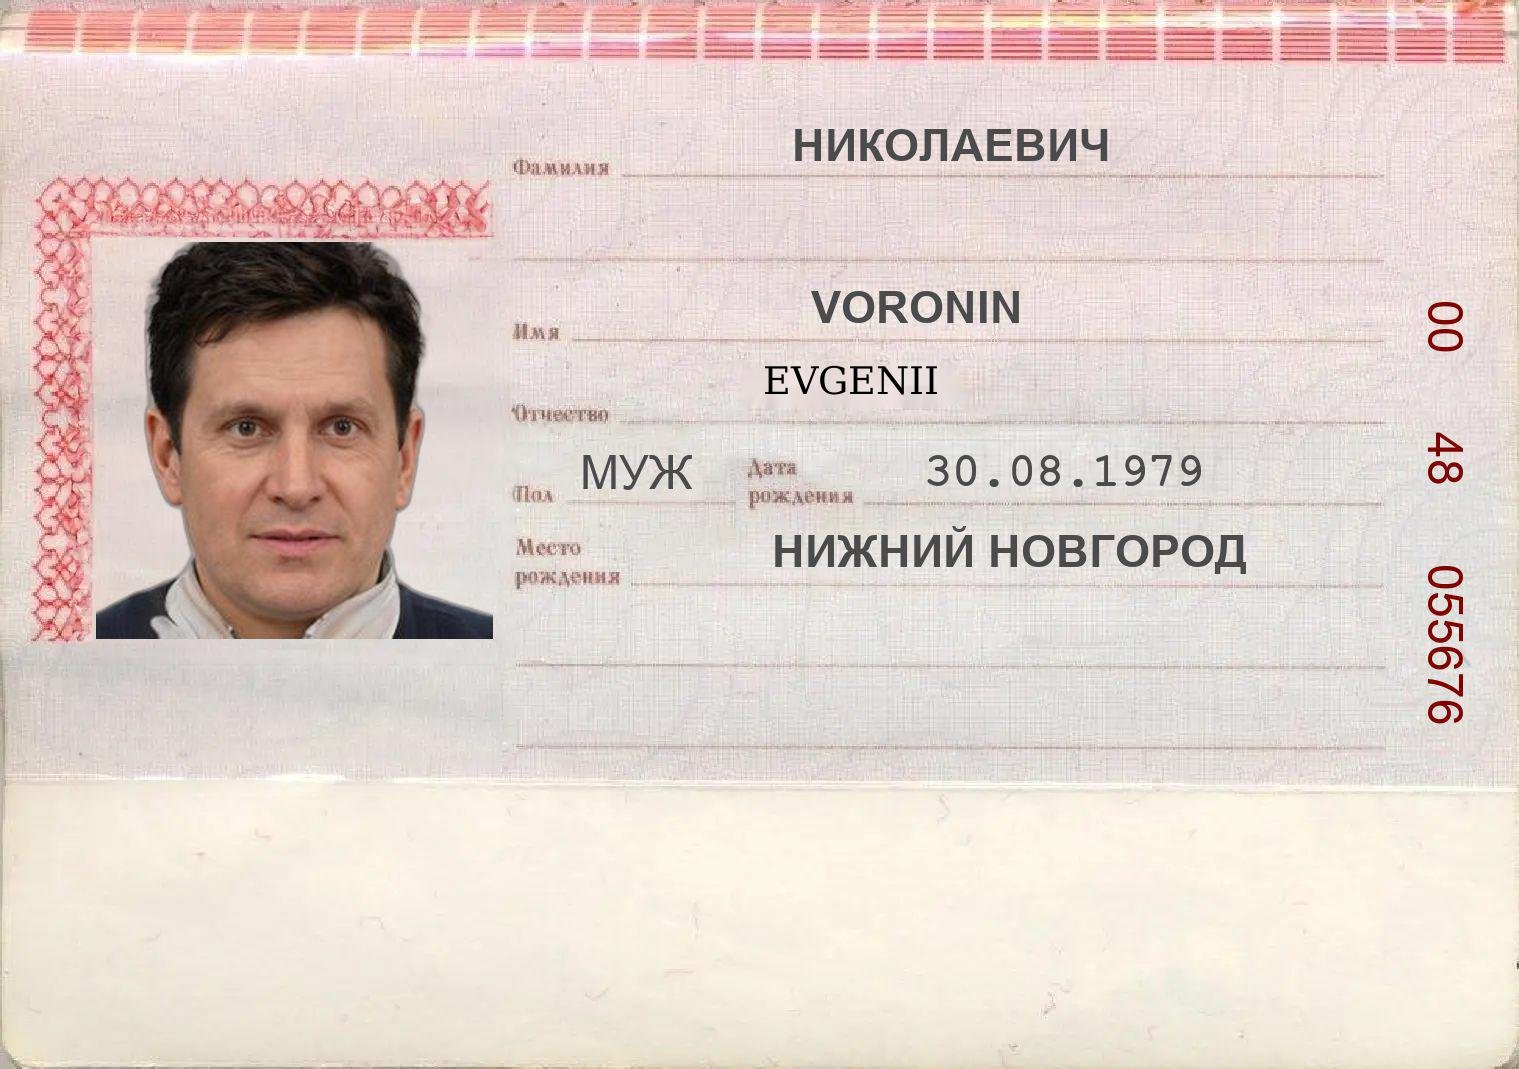
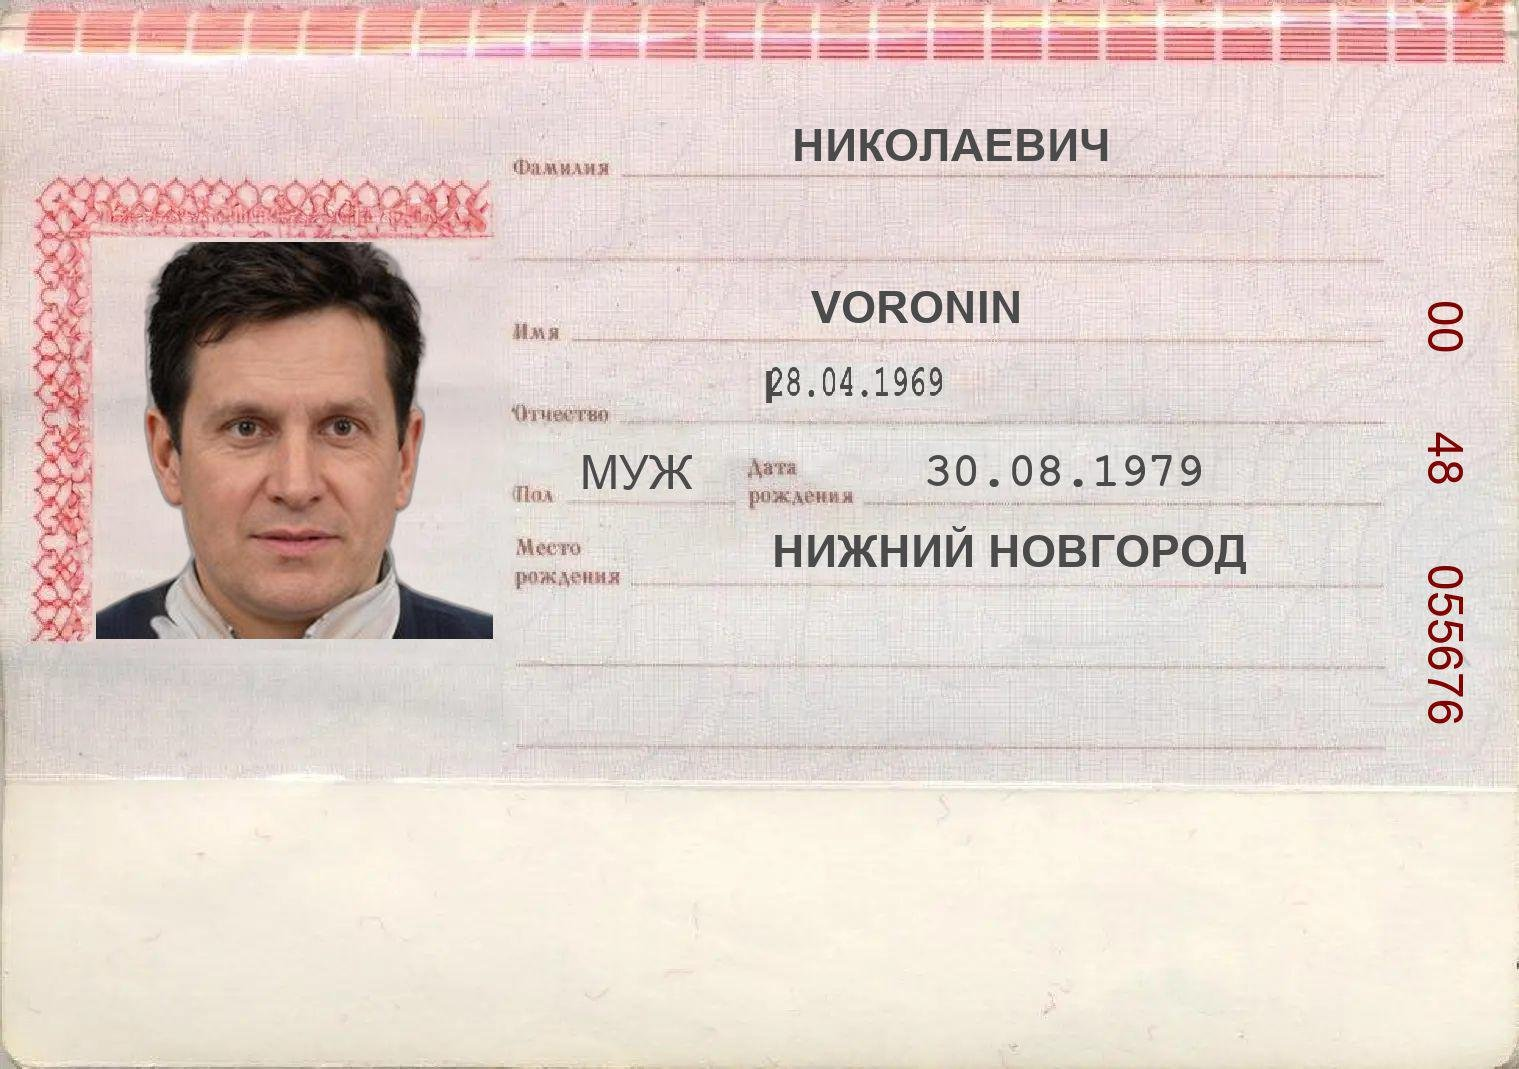
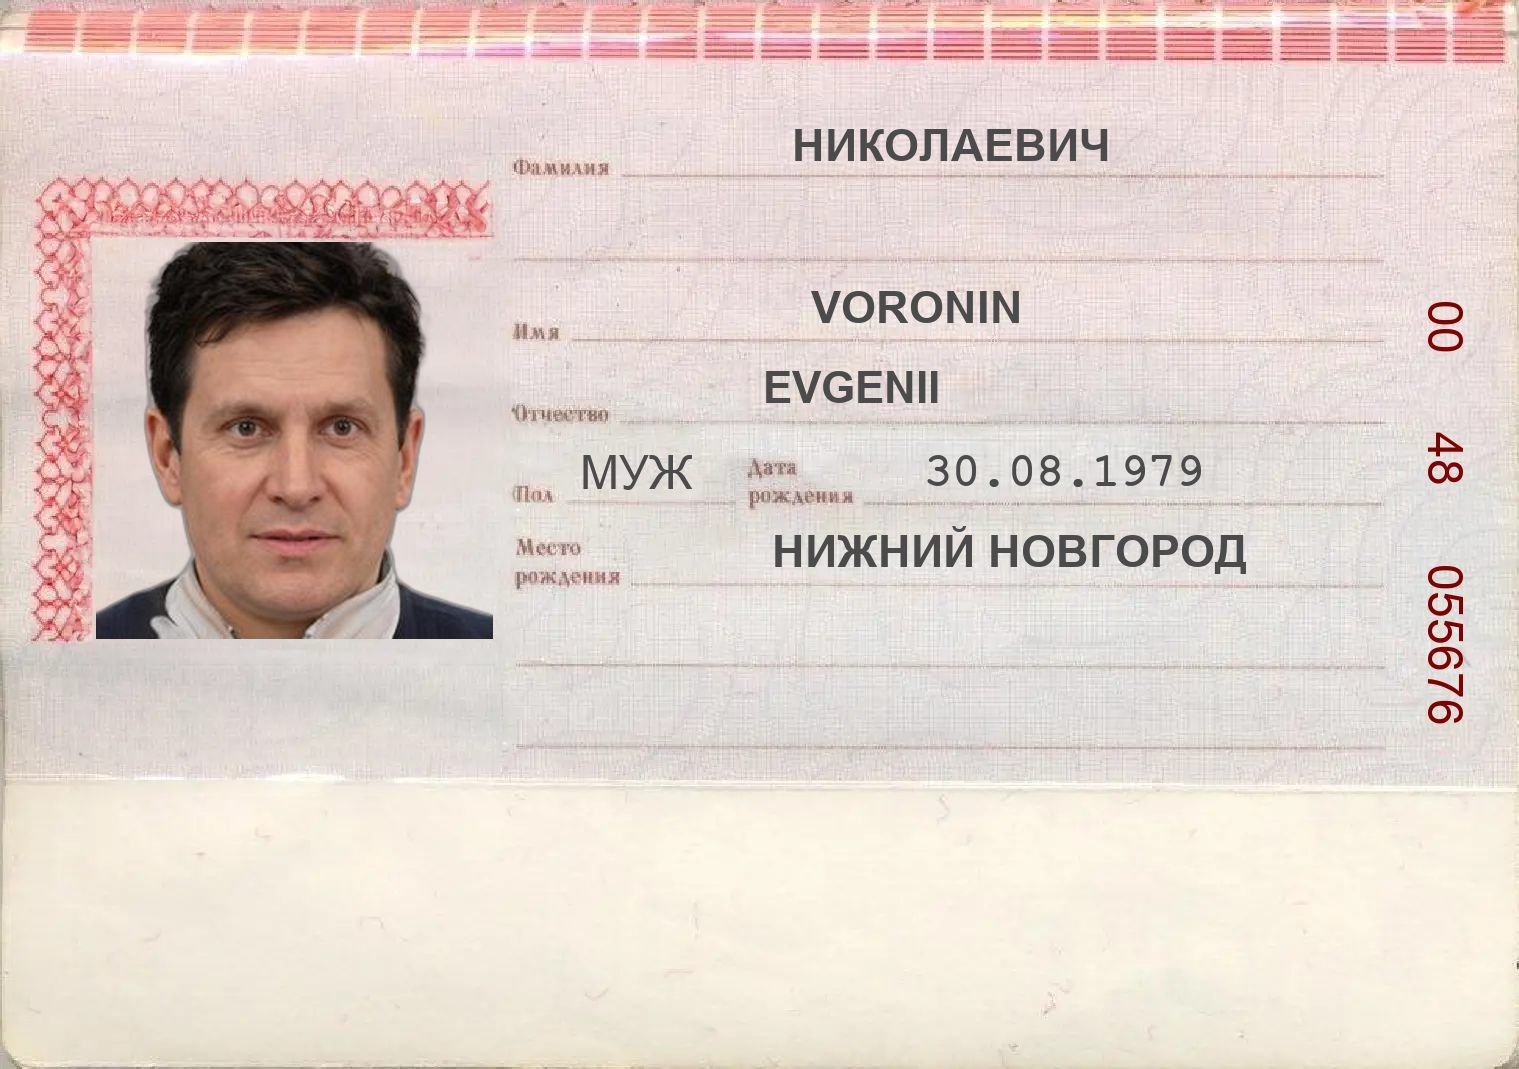
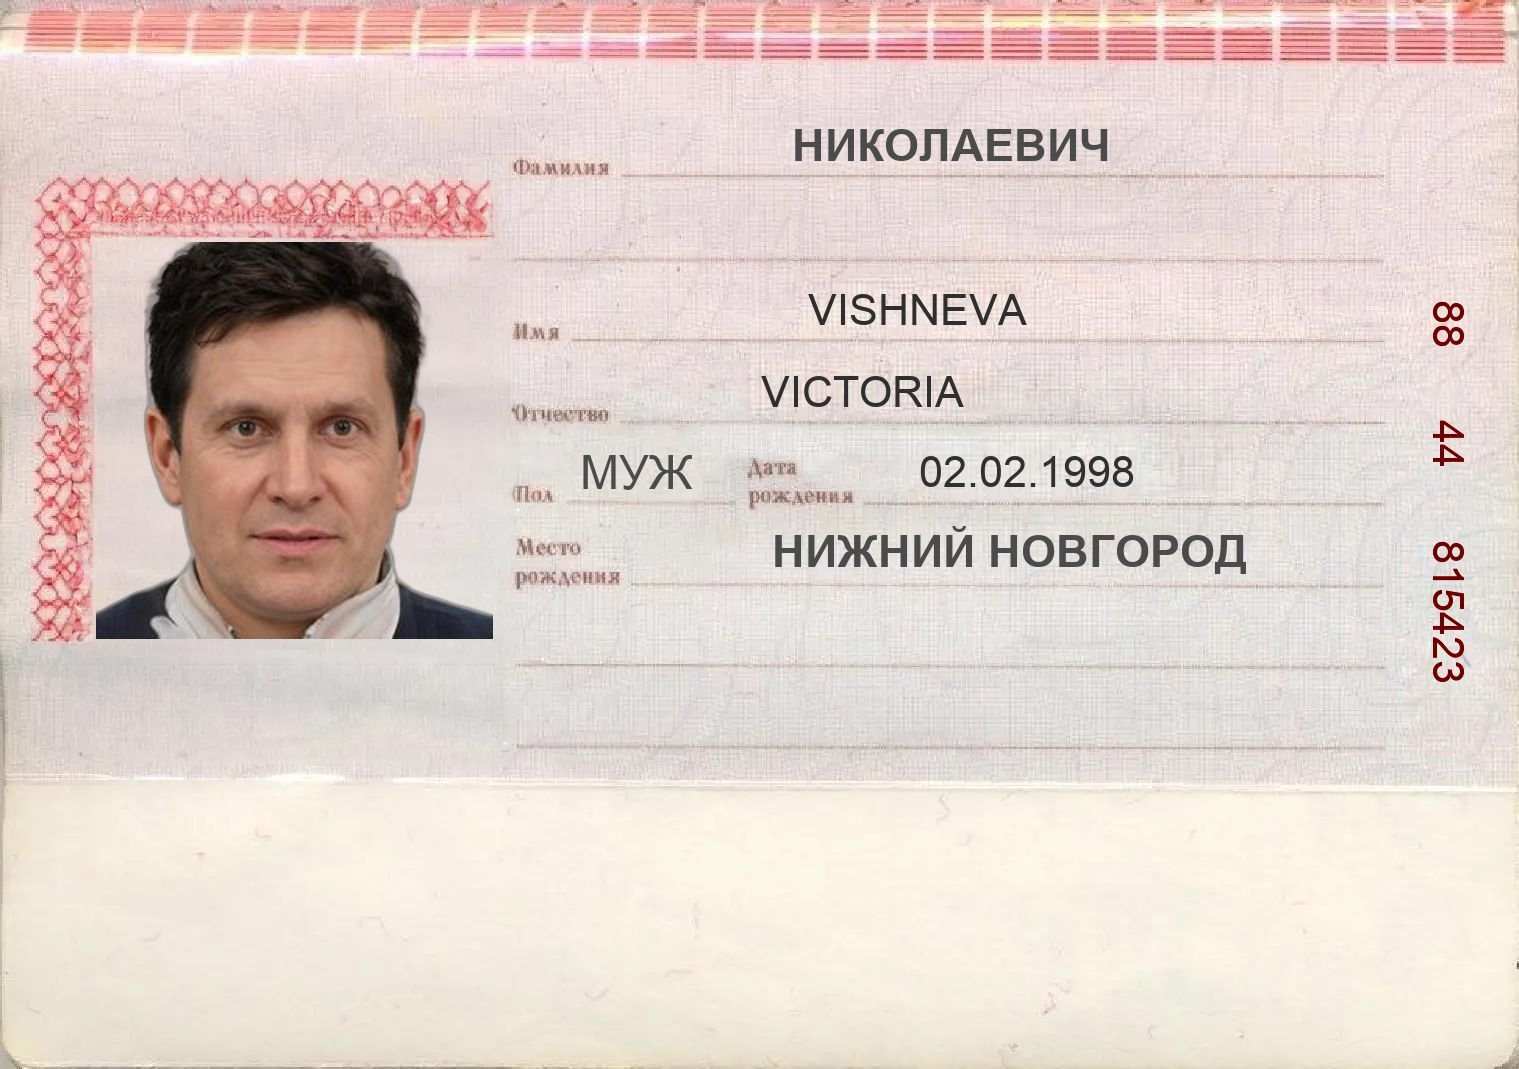
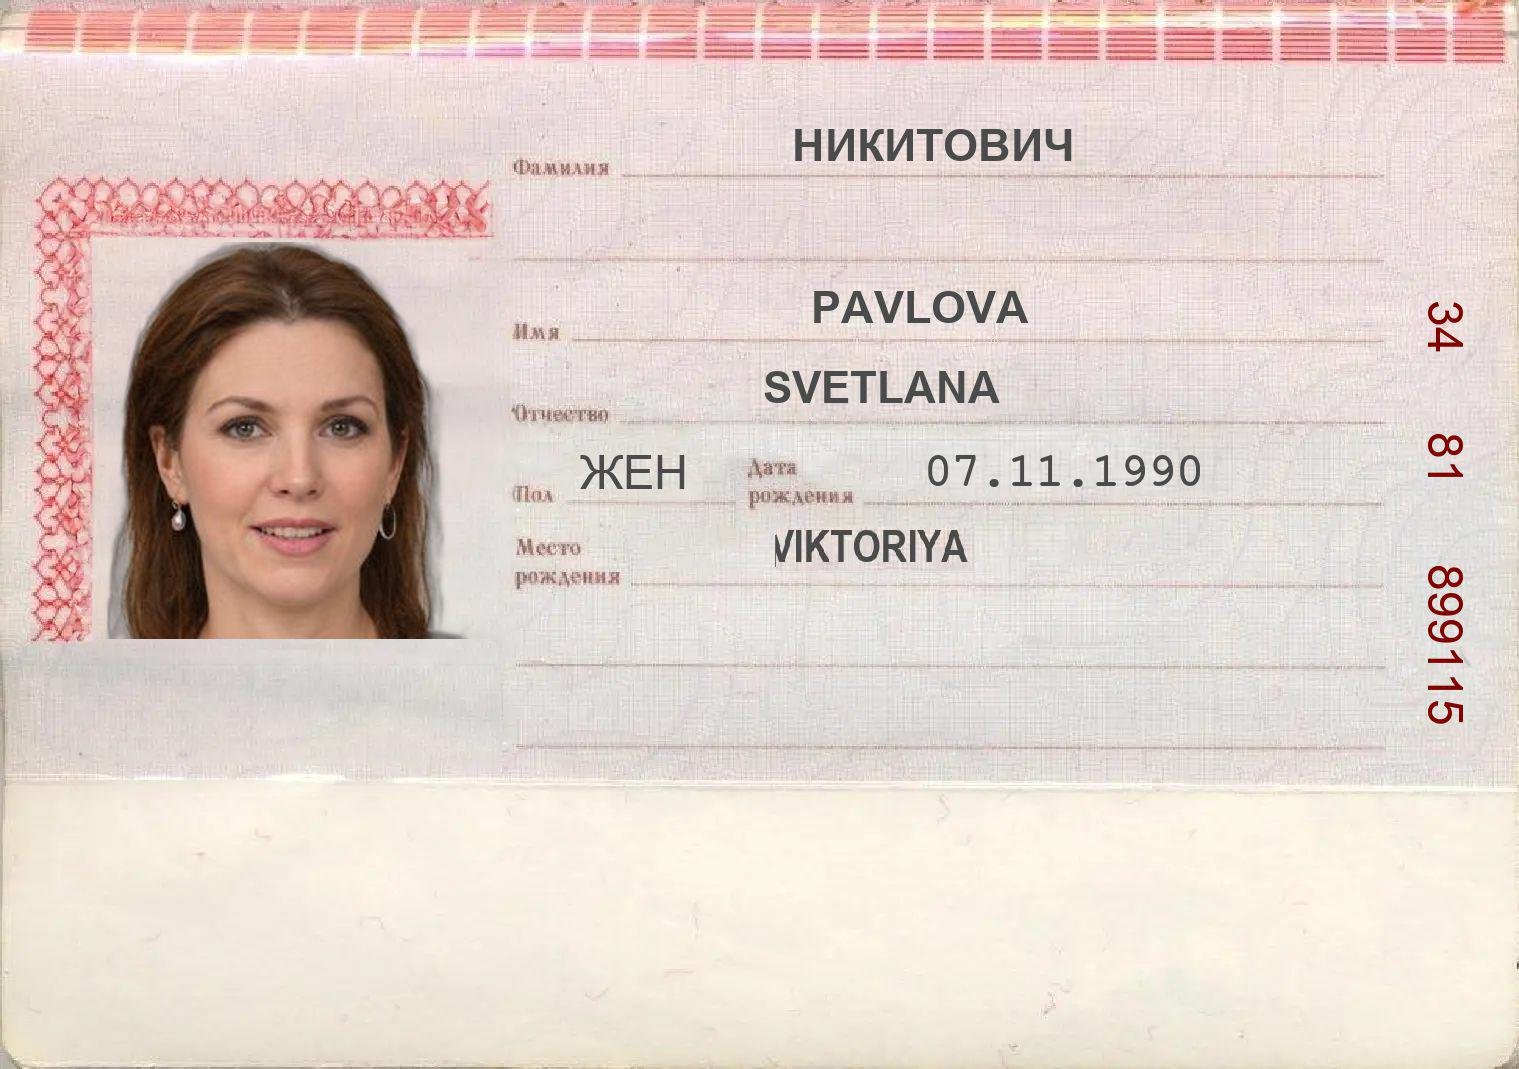

In [ ]:
import base64
import io
import json
import cv2
import numpy as np
from IPython.display import display, HTML
from PIL import Image
import html

# --- Helper: Convert Image to Base64 ---
def img_to_base64(img):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG", quality=85)
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/jpeg;base64,{img_str}"

# --- ENHANCED SEARCH PIPELINE ---
def search_pipeline_explainable(query_image_path, k=5, alpha=0.5):
    """
    Hybrid search that returns detailed mathematical justification for every step.
    """
    query_img = Image.open(query_image_path).convert("RGB")
    img_cv2 = cv2.imread(query_image_path)
    
    logs = [] # Store technical logs
    
    # 1. Face Analysis (Geometric Matching)
    face_scores = np.zeros(len(metadata_store))
    face_distances = np.full(len(metadata_store), 999.0) # Default high distance
    
    if alpha > 0:
        faces = face_app.get(img_cv2)
        if len(faces) > 0:
            q_emb = faces[0].normed_embedding.reshape(1, -1).astype('float32')
            
            # FAISS L2 Search
            D, I = face_index.search(q_emb, k * 20) # Search wider to get distribution
            
            logs.append(f"🧠 <b>ArcFace Embedding:</b> Successfully extracted 512-d vector from query face.")
            logs.append(f"📐 <b>Geometric Constraint:</b> Nearest neighbor L2 distance is {D[0][0]:.4f}.")
            
            for rank, idx in enumerate(I[0]):
                if idx == -1: continue
                dist = D[0][rank]
                face_distances[idx] = dist
                # Convert L2 Distance (0 to inf) to Similarity (0 to 1)
                # Formula: Sim = 1 / (1 + Distance)
                face_scores[idx] = 1 / (1 + dist)
        else:
            logs.append("⚠️ <b>Face Detection Failed:</b> No valid face found in query image (RetinaFace).")

    # 2. Text Analysis (Semantic Matching)
    text_scores = np.zeros(len(metadata_store))
    
    if alpha < 1:
        extracted_text = extract_text_donut(query_img)
        # Sanitize text snippet for the log immediately
        safe_snippet = extracted_text[:100].replace("<s>", "") 
        logs.append(f"👁️ <b>Donut OCR:</b> generated text sequence: <i>'{safe_snippet}...'</i>")
        
        q_vec = tfidf_vectorizer.transform([extracted_text])
        sims = cosine_similarity(q_vec, text_matrix).flatten()
        text_scores = sims
        
        logs.append(f"📚 <b>Semantic Density:</b> Text vector matches {np.count_nonzero(sims > 0.5)} documents with >0.5 similarity.")

    # 3. Fusion
    final_scores = (alpha * face_scores) + ((1 - alpha) * text_scores)
    top_indices = np.argsort(final_scores)[::-1][:k]
    
    results = []
    for idx in top_indices:
        # --- SAFETY FIX IS HERE ---
        # Retrieve values from the arrays we initialized at the top
        f_score = face_scores[idx]
        t_score = text_scores[idx]
        f_dist = face_distances[idx]  # Now safe because array is pre-filled with 999.0
        
        decision_logic = []
        if f_score > 0.7: decision_logic.append("Strong Biometric Match")
        elif f_score < 0.3: decision_logic.append("Biometric Mismatch")
        if t_score > 0.8: decision_logic.append("Exact Semantic Match")
        elif t_score < 0.2: decision_logic.append("Semantic Divergence")
        
        results.append({
            "id": idx,
            "score": final_scores[idx],
            "face_score": f_score,
            "text_score": t_score,
            "l2_distance": f_dist,
            "justification": ", ".join(decision_logic),
            "metadata": metadata_store[idx]
        })
        
    return results, query_img, logs
    """
    Hybrid search that returns detailed mathematical justification for every step.
    """
    query_img = Image.open(query_image_path).convert("RGB")
    img_cv2 = cv2.imread(query_image_path)
    
    logs = [] # Store technical logs
    
    # 1. Face Analysis (Geometric Matching)
    face_scores = np.zeros(len(metadata_store))
    face_distances = np.full(len(metadata_store), 999.0) # Default high distance
    
    if alpha > 0:
        faces = face_app.get(img_cv2)
        if len(faces) > 0:
            q_emb = faces[0].normed_embedding.reshape(1, -1).astype('float32')
            
            # FAISS L2 Search
            D, I = face_index.search(q_emb, k * 20) # Search wider to get distribution
            
            logs.append(f"🧠 <b>ArcFace Embedding:</b> Successfully extracted 512-d vector from query face.")
            logs.append(f"📐 <b>Geometric Constraint:</b> Nearest neighbor L2 distance is {D[0][0]:.4f}.")
            
            for rank, idx in enumerate(I[0]):
                if idx == -1: continue
                dist = D[0][rank]
                face_distances[idx] = dist
                # Convert L2 Distance (0 to inf) to Similarity (0 to 1)
                face_scores[idx] = 1 / (1 + dist)
        else:
            logs.append("⚠️ <b>Face Detection Failed:</b> No valid face found in query image (RetinaFace).")

    # 2. Text Analysis (Semantic Matching)
    text_scores = np.zeros(len(metadata_store))
    extracted_text_snippet = ""
    
    if alpha < 1:
        extracted_text = extract_text_donut(query_img)
        # Sanitize text snippet for the log immediately
        safe_snippet = extracted_text[:100].replace("<s>", "") 
        logs.append(f"👁️ <b>Donut OCR:</b> generated text sequence: <i>'{safe_snippet}...'</i>")
        
        q_vec = tfidf_vectorizer.transform([extracted_text])
        sims = cosine_similarity(q_vec, text_matrix).flatten()
        text_scores = sims
        
        logs.append(f"📚 <b>Semantic Density:</b> Text vector matches {np.count_nonzero(sims > 0.5)} documents with >0.5 similarity.")

    # 3. Fusion
    final_scores = (alpha * face_scores) + ((1 - alpha) * text_scores)
    top_indices = np.argsort(final_scores)[::-1][:k]
    
    results = []
    for idx in top_indices:
        # Justification Logic
        f_score = face_scores[idx]
        t_score = text_scores[idx]
        decision_logic = []
        if f_score > 0.7: decision_logic.append("Strong Biometric Match")
        elif f_score < 0.3: decision_logic.append("Biometric Mismatch")
        if t_score > 0.8: decision_logic.append("Exact Semantic Match")
        elif t_score < 0.2: decision_logic.append("Semantic Divergence")
        
        results.append({
            "id": idx,
            "score": final_scores[idx],
            "face_score": f_score,
            "text_score": t_score,
            "l2_distance": f_dist,
            "justification": ", ".join(decision_logic),
            "metadata": metadata_store[idx]
        })
        
    return results, query_img, logs

# --- ENHANCED DASHBOARD RENDERER ---
def render_explainable_dashboard(query_img, results, logs, k, alpha):
    
    top_score = results[0]['score'] if results else 0
    query_b64 = img_to_base64(query_img)
    
    # --- FIX: PRESERVE BOLD BUT KILL STRIKETHROUGH ---
    clean_logs = []
    for log_entry in logs:
        # Replace <s> with HTML entity so it prints as text, doesn't strike through
        safe_log = log_entry.replace("<s>", "&lt;s&gt;").replace("</s>", "&lt;/s&gt;")
        clean_logs.append(safe_log)
    log_html = "<br>".join(clean_logs)
    # --------------------------------------------------

    style = """
    <style>
        .dash { font-family: 'Segoe UI', sans-serif; background: #0f172a; color: #f1f5f9; padding: 20px; border-radius: 12px; }
        .card { background: #1e293b; border: 1px solid #334155; border-radius: 8px; padding: 15px; margin-bottom: 15px; }
        .metric-row { display: flex; gap: 15px; margin-bottom: 20px; }
        .metric { background: #334155; flex: 1; padding: 15px; border-radius: 8px; text-align: center; }
        .metric h2 { margin: 0; color: #38bdf8; font-size: 24px; }
        .metric p { margin: 5px 0 0; font-size: 12px; color: #94a3b8; }
        .result-row { display: flex; gap: 15px; border-top: 1px solid #334155; padding-top: 15px; }
        .img-box { width: 150px; height: 110px; background: black; display: flex; align-items: center; justify-content: center; flex-shrink: 0; }
        .img-box img { max-width: 100%; max-height: 100%; }
        .tech-details { font-family: monospace; font-size: 11px; color: #cbd5e1; background: #020617; padding: 10px; border-radius: 4px; margin-top: 5px; }
        .log-box { background: #000; color: #22c55e; font-family: monospace; padding: 10px; font-size: 12px; border-radius: 4px; margin-bottom: 20px; border: 1px solid #22c55e; max-height: 200px; overflow-y: auto; white-space: pre-wrap; }
    </style>
    """
    
    html_content = f"""
    {style}
    <div class="dash">
        <div style="display:flex; justify-content:space-between; align-items:center; margin-bottom:20px;">
            <h1 style="margin:0; color:#38bdf8;">Sparrow <span style="color:#fff; font-weight:300;">Explainable Identity Verification</span></h1>
            <div style="font-size:12px; background:#334155; padding:5px 10px; border-radius:15px;">v2.5 (Physics-Informed)</div>
        </div>

        <!-- Technical Logs -->
        <div class="log-box">
            <strong>SYSTEM KERNEL LOGS:</strong><br>
            {log_html}
        </div>

        <div style="display:grid; grid-template-columns: 1fr 2fr; gap:20px;">
            <!-- Left: Query & Metrics -->
            <div>
                <div class="card" style="text-align:center;">
                    <img src="{query_b64}" style="max-width:100%; border-radius:4px;">
                    <div style="margin-top:10px; font-size:12px; color:#94a3b8;">QUERY INPUT ARTIFACT</div>
                </div>
                
                <div class="metric-row">
                    <div class="metric">
                        <h2>{alpha:.1f}</h2>
                        <p>Alpha (Face Weight)</p>
                    </div>
                    <div class="metric">
                        <h2>{top_score*100:.1f}%</h2>
                        <p>Top Confidence</p>
                    </div>
                </div>
                
                <div class="metric">
                     <h2>{len(results)}</h2>
                     <p>Candidates Analyzed</p>
                </div>
            </div>

            <!-- Right: Detailed Results -->
            <div>
                <h3 style="margin-top:0; border-bottom:1px solid #334155; padding-bottom:10px;">Top {len(results)} Candidates (Decision Manifold)</h3>
    """

    for i, res in enumerate(results):
        match_img = hf_dataset[int(res['id'])]['image']
        match_b64 = img_to_base64(match_img)
        
        try:
            meta = json.loads(res['metadata']['data'])
            status = "FRAUD" if meta.get('is_fraud') else "AUTHENTIC"
            color = "#ef4444" if meta.get('is_fraud') else "#22c55e"
            fraud_type = meta.get('fraud_type', 'None')
        except:
            status = "UNKNOWN"
            color = "#64748b"
            fraud_type = "Parsing Error"

        final_calc = f"({alpha} × {res['face_score']:.2f}) + ({1-alpha:.1f} × {res['text_score']:.2f})"
        
        html_content += f"""
                <div class="card result-row">
                    <div class="img-box">
                        <img src="{match_b64}">
                    </div>
                    <div style="flex:1;">
                        <div style="display:flex; justify-content:space-between;">
                            <div style="font-weight:bold; color:{color}; font-size:16px;">#{i+1} {status} <span style="font-size:12px; color:#94a3b8;">({fraud_type})</span></div>
                            <div style="font-family:monospace; font-size:14px;">Score: {res['score']:.4f}</div>
                        </div>
                        
                        <div class="tech-details">
                            <div><strong>🔍 Decision Logic:</strong> {res['justification']}</div>
                            <div style="margin-top:4px; color:#94a3b8;">
                                <strong>MATH:</strong> Final = {final_calc}<br>
                                <strong>FACE:</strong> L2_Dist={res['l2_distance']:.2f} → Score={res['face_score']:.2f}<br>
                                <strong>TEXT:</strong> TF-IDF Cosine Similarity = {res['text_score']:.4f}
                            </div>
                        </div>
                    </div>
                </div>
        """

    html_content += """
            </div>
        </div>
    </div>
    """
    display(HTML(html_content))

# --- MAIN EXECUTION ---
print("📂 Select a query ID card image...")
query_path = select_file("Select Query Image")

if query_path:
    mode_input = input("Select Mode: [1] Face Only  [2] Text Only  [3] Hybrid (Default): ")
    alpha = 1.0 if mode_input == '1' else (0.0 if mode_input == '2' else 0.5)
    
    # INCREASED K TO 10
    k_value = 10
    
    results, q_img, logs = search_pipeline_explainable(query_path, k=k_value, alpha=alpha)
    render_explainable_dashboard(q_img, results, logs, k=k_value, alpha=alpha)
else:
    print("❌ No file selected.")